In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# **IDEA -1 BI-GRU & LSTM WITH DUAL EMBEDDINGS(FAST TEXT + GLOVE).**

In [ ]:
#Importing all the libraries 

import time
start_time = time.time()
from sklearn.model_selection import train_test_split
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
# from keras.engine import InputSpec, Layer
from keras.layers import Layer
from keras.layers import InputSpec
import logging
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
import warnings
warnings.filterwarnings("ignore")
import_time = round((time.time()-start_time)*1000,3)

np.random.seed(32)
os.environ["OMP_NUM_THREADS"] = "4"
print(f"'ALL LIBRARIES IMPORTED SUCCESSFULLY!!' in TIME : {import_time} msec")


In [ ]:
#Customized Class to handle ROC AUC Evaluation for each epoch and printing epoch number and score for each epoch which is multiple of interval.  
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))
            
            

In [ ]:
#Reading the training and testing data i.e converting that into dataframes
train = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
test  = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/test.csv")

In [ ]:
train.head(10)

In [ ]:
test.head(10)

In [ ]:
#Columns of training data
train.columns

In [ ]:
train.info()

In [ ]:
#Columns of test data
test.columns

In [ ]:
test.info()

In [ ]:
embedding_path_fastText = "../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec"
embedding_path_glove    = "../input/glove840b300dtxt/glove.840B.300d.txt"
embed_size = 300
max_features = 130000 #Vocabulary Size 
max_len = 220  # maximum length of tweet. 

In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
train["comment_text"].fillna("no comment")
test["comment_text"].fillna("no comment")


validation_size = 0.1 
# splitting train:dev -->  9:1 so train consist of 90 percent and validation set consist of 10 percent of entire training data 
#Note : This validation_size is configurable and can be changed later.
X_train, X_valid, Y_train, Y_valid = train_test_split(train, y, test_size = validation_size)



# Lowering all the comments of training, validation and test data let callled it as raw.
raw_text_train = X_train["comment_text"].str.lower()
raw_text_valid = X_valid["comment_text"].str.lower()
raw_text_test = test["comment_text"].str.lower()

In [ ]:
# Artcle for better undrstanding of Tokenizer : https://machinelearningknowledge.ai/keras-tokenizer-tutorial-with-examples-for-fit_on_texts-texts_to_sequences-texts_to_matrix-sequences_to_matrix/

# num_words = the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
tk = Tokenizer(num_words = max_features)
#Tokeinzing the raw training set
tk.fit_on_texts(raw_text_train)
# print(raw_text_train.shape )
X_train["comment_seq"] = tk.texts_to_sequences(raw_text_train)
X_valid["comment_seq"] = tk.texts_to_sequences(raw_text_valid)
test["comment_seq"] = tk.texts_to_sequences(raw_text_test)

X_train = pad_sequences(X_train.comment_seq, maxlen = max_len)
X_valid = pad_sequences(X_valid.comment_seq, maxlen = max_len)
test = pad_sequences(test.comment_seq, maxlen = max_len)

In [ ]:
test

In [ ]:
X_train

In [ ]:
X_valid

In [ ]:
# Creating Embeeding Index which can help further to create embedding matrix for the words in our training dataset vocabulary.
# This Ebedding index is created from the fastText or Glove.
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')

#Embedding Index correpsonding to FastText
embedding_index_fastText = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path_fastText))

#Embedding Index correpsonding to Glove
embedding_index_glove = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path_glove))

In [ ]:
print(type(embedding_index_fastText))

In [ ]:
print(type(embedding_index_glove))

In [ ]:
len(embedding_index_fastText.keys())

In [ ]:
len(embedding_index_glove.keys())

In [ ]:
len(embedding_index_fastText['spam'])

In [ ]:
len(embedding_index_glove['spam'])

In [ ]:
embedding_index_fastText['spam'][:10]

In [ ]:
embedding_index_glove['spam'][:10]

In [ ]:
embedding_index_fastText['spam'][-10+1:]

In [ ]:
embedding_index_glove['spam'][-10+1:]

In [ ]:
# Preparing Our Embeeding matrix from Embedding Index from glove or fastText. 
damword_index = tk.word_index
nb_words = min(max_features, len(damword_index))
embedding_matrix_fastText = np.zeros((nb_words, embed_size))
embedding_matrix_glove = np.zeros((nb_words, embed_size))

for word, i in damword_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index_fastText.get(word)
    if embedding_vector is not None: embedding_matrix_fastText[i] = embedding_vector
        
for word, i in damword_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index_glove.get(word)
    if embedding_vector is not None: embedding_matrix_glove[i] = embedding_vector

In [ ]:
embedding_matrix_fastText[2][:10]

In [ ]:
embedding_matrix_glove[2][:10]

In [ ]:
len(embedding_matrix_fastText[2])

In [ ]:
len(embedding_matrix_glove[2])

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop
# from keras.optimizers import  RMSprop, adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import GRU, BatchNormalization, Conv1D, MaxPooling1D


In [ ]:
file_path = "best_model_idea1.hdf5"  #Nmae by whihc Model is to be saved 
check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                              save_best_only = True, mode = "min")
ra_val = RocAucEvaluation(validation_data=(X_valid, Y_valid), interval = 1)

#Allowing early stopping
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)

In [ ]:
def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0, epochs=10):
    inp = Input(shape = (max_len,))
    x_fastText = Embedding(max_features, embed_size, weights = [embedding_matrix_fastText], trainable = False)(inp)# Let this layer be the FatText input embedding
    x_glove = Embedding(max_features, embed_size, weights = [embedding_matrix_glove], trainable = False)(inp)# Let this layer be the Glove input embedding
    
    #Drop-Out Layer
    x1_fastText = SpatialDropout1D(dr)(x_fastText)
    x1_glove = SpatialDropout1D(dr)(x_glove)

    ### FastText
    #BI-GRU , FastText
    x_gru_fastText = Bidirectional(GRU(units, return_sequences = True))(x1_fastText)
    x_conv_gru_fastText = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_gru_fastText)
    
    #BI-LSTM , FastText
    x_lstm_fastText = Bidirectional(LSTM(units, return_sequences = True))(x1_fastText)
    x_conv_lstm_fastText = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_lstm_fastText)
    
    ### Glove
    #BI-GRU , Glove
    x_gru_glove = Bidirectional(GRU(units, return_sequences = True))(x1_glove)
    x_conv_gru_glove = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_gru_glove)
    
    #BI-LSTM , Glove
    x_lstm_glove = Bidirectional(LSTM(units, return_sequences = True))(x1_glove)
    x_conv_lstm_glove = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_lstm_glove)
    
    
    ### FastText
    #POOLING_CONV ,BI-GRU, FastText
    avg_pool1_gru_fastText = GlobalAveragePooling1D()(x_conv_gru_fastText)
    max_pool1_gru_fastText = GlobalMaxPooling1D()(x_conv_gru_fastText)
    
    #POOLING_CONV ,BI-LSTM, FastText
    avg_pool2_lstm_fastText = GlobalAveragePooling1D()(x_conv_lstm_fastText)
    max_pool2_lstm_fastText = GlobalMaxPooling1D()(x_conv_lstm_fastText)
    
    
    ### Glove
    #POOLING_CONV ,BI-GRU, Glove
    avg_pool1_gru_glove = GlobalAveragePooling1D()(x_conv_gru_glove)
    max_pool1_gru_glove = GlobalMaxPooling1D()(x_conv_gru_glove)
    
    #POOLING_CONV ,BI-LSTM, Glove
    avg_pool2_lstm_glove = GlobalAveragePooling1D()(x_conv_lstm_glove)
    max_pool2_lstm_glove = GlobalMaxPooling1D()(x_conv_lstm_glove)
    
    
    #Concatenating FastText Branch
    x_fastText = concatenate([avg_pool1_gru_fastText, max_pool1_gru_fastText, avg_pool2_lstm_fastText, max_pool2_lstm_fastText])
    
    #Concatenating Glove Branch
    x_glove = concatenate([avg_pool1_gru_glove, max_pool1_gru_glove, avg_pool2_lstm_glove, max_pool2_lstm_glove])
  
    
#     x = x_fastText  #Comment this line when below line got  un-commented
    #Finally Concatenating Both the branches
    x = concatenate([x_fastText, x_glove])
    
    #Passing concatenated output to dense network
    x = Dense(6, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
#     model.compile(loss = "binary_crossentropy", optimizer = adam_v2.Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    history = model.fit(X_train, Y_train, batch_size = 128, epochs = epochs, validation_data = (X_valid, Y_valid), 
                        verbose = 1, callbacks = [ra_val, check_point, early_stop])
    model = load_model(file_path)
    return model,history
    
    


In [ ]:
#Trainng The Model
model,history = build_model(lr = 1e-3, lr_d = 0, units = 112, dr = 0.2,epochs = 3)


In [ ]:
#Predicting The Model

pred = model.predict(test, batch_size = 1024, verbose = 1)

submission = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv")
submission[list_classes] = (pred)
submission.to_csv("submission.csv", index = False)
print("[{}] Completed!".format(time.time() - start_time))

In [ ]:
test.shape

In [ ]:
test[0].shape

In [ ]:
pred.shape

In [ ]:
pred[0]

In [ ]:
pred[132]

In [ ]:
#ROC-AUC Evaluation  
# https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/


y_pred_validation = model.predict(X_valid, verbose=1)
score_validation = roc_auc_score(Y_valid, y_pred_validation)
print(f"\n ROC-AUC - ON Validation Dataset - score: {round(score_validation,5)*100}%")

In [ ]:
y_pred_train = model.predict(X_train, verbose=1)
score_train = roc_auc_score(Y_train, y_pred_train)
print(f"\n ROC-AUC - Training Dataset - score: {round(score_train,5)*100}%")

In [ ]:
Y_train

In [ ]:
Y_valid

In [ ]:
pred = model.predict(X_valid,verbose=1)
# pred_prob = model.predict_proba(X_valid)



In [ ]:
X_valid[0]

In [ ]:
len(pred)

In [ ]:
len(pred[0])

In [ ]:
pred

In [ ]:
import matplotlib.pyplot as plt

def Plot(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("EPOCHS")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string ])
    plt.savefig(string + '_IDEA1.png')
    plt.show()
    
    
Plot(history, "accuracy")
Plot(history, "loss")


print("###### DONE PLOTTING FOR IDEA 1 ########")

# **ROC-AUC PLOTTING**

In [ ]:
predict_probability = np.zeros(shape=pred.shape,dtype='int64')
no_classes = len(pred[0])
no_of_examples = len(pred)
for i in range(no_of_examples):
    maxi_index = 0
    maximum_element = pred[i][0]
    for j in range(1,no_classes):
        if maximum_element<pred[i][j]:
            maximum_element = pred[i][j]
            maxi_index = j
    predict_probability[i][maxi_index] = 1
      
            
        
    
        
        

In [ ]:
predict_probability

In [ ]:
predict_probability.dtype

In [ ]:
Y_valid.dtype

In [ ]:
Y_valid

In [ ]:
# roc_pred = np.zeros(no_of_examples,dtype='int64')
# for i in range(no_of_examples):
#     for j in range(no_classes):
#         if pred[i][j]==1:
#             roc_pred[i]=j
#             break
            
            
y_validation = np.zeros(no_of_examples,dtype='int64')
for i in range(no_of_examples):
    for j in range(no_classes):
        if Y_valid[i][j]==1:
            y_validation[i]=j
            break

In [ ]:
# roc curve for classes
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr = {}
tpr = {}
thresh ={}

n_class = no_classes

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_validation, predict_probability[:,i], pos_label=i)
    


In [ ]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='brown', label='Class 5 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [ ]:
# #  multi-class classification
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt

# # generate 2 class dataset
# X, y = make_classification(n_samples=1000, n_classes=3, n_features=20, n_informative=3, random_state=42)

# # split into train/test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# # fit model
# clf = OneVsRestClassifier(LogisticRegression())
# clf.fit(X_train, y_train)
# pred = clf.predict(X_test)
# pred_prob = clf.predict_proba(X_test)

# # roc curve for classes
# fpr = {}
# tpr = {}
# thresh ={}

# n_class = 3



# for i in range(n_class):    
#     fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# # plotting    
# plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
# plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
# plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
# plt.title('Multiclass ROC curve')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive rate')
# plt.legend(loc='best')
# plt.savefig('Multiclass ROC',dpi=300);    

In [ ]:
y_train.shape

In [ ]:
pred

In [ ]:
pred_prob

In [ ]:
y_test

In [ ]:
X.shape

In [ ]:
embedding_matrix_fastText.shape

In [ ]:
embedding_matrix_glove.shape

#  **DUAL EMBEDDINGS**

In [ ]:
# import numpy as np
# import pandas as pd
# import os
# from keras.models import Model
# from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
# from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, CuDNNGRU, Conv1D
# from keras.preprocessing import text, sequence
# from keras.callbacks import LearningRateScheduler
# from sklearn.metrics import roc_auc_score
# from sklearn.model_selection import train_test_split
# import tensorflow as tf
# print(tf.__version__)
# tf.test.is_gpu_available(
#     cuda_only=False,
#     min_cuda_compute_capability=None
# )

In [ ]:
# EMBEDDING_FILES = [
#         '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec',
#     '../input/glove840b300dtxt/glove.840B.300d.txt'
# ]


# BATCH_SIZE = 512
# LSTM_UNITS = 128
# DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
# EPOCHS = 4
# MAX_LEN = 220


# TEXT_COLUMN = 'comment_text'
# list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
# CHARS_TO_REMOVE = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'

In [ ]:
# train_df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv')
# test_df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv')
# submission = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv")

# y = train_df[list_classes].values
# x_train = train_df[TEXT_COLUMN].astype(str)
# y_train = y
# x_test = test_df[TEXT_COLUMN].astype(str)

In [ ]:
# def get_coefs(word, *arr):
#     return word, np.asarray(arr, dtype='float32')


# def load_embeddings(path):
#     with open(path) as f:
#         return dict(get_coefs(*line.strip().split(' ')) for line in f)


# def build_matrix(word_index, path):
#     embedding_index = load_embeddings(path)
#     embedding_matrix = np.zeros((len(word_index) + 1, 300))
#     for word, i in word_index.items():
#         try:
#             embedding_matrix[i] = embedding_index[word]
#         except KeyError:
#             pass
#     return embedding_matrix

# def build_model(embedding_matrix):
#     words = Input(shape=(None,))
#     x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
#     #x = SpatialDropout1D(0.2)(x)

#     x1 = SpatialDropout1D(0.2)(x)

#     x = Bidirectional(CuDNNGRU(LSTM_UNITS, return_sequences = True))(x1)
#     x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    
#     y = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences = True))(x1)
#     y = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(y)


#     avg_pool1 = GlobalAveragePooling1D()(x)
#     max_pool1 = GlobalMaxPooling1D()(x)
   
#     avg_pool2 = GlobalAveragePooling1D()(y)
#     max_pool2 = GlobalMaxPooling1D()(y)
   

#     x = concatenate([avg_pool1, max_pool1, avg_pool2, max_pool2])


#     x = Dense(6, activation = "sigmoid")(x)

#     model = Model(inputs = words, outputs = x)

#     model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

#     return model

In [ ]:
# %%time
# tokenizer = text.Tokenizer(filters=CHARS_TO_REMOVE)
# tokenizer.fit_on_texts(list(x_train) + list(x_test))

# x_train = tokenizer.texts_to_sequences(x_train)
# x_test = tokenizer.texts_to_sequences(x_test)
# x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
# x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)

In [ ]:
# %%time
# embedding_matrix = np.concatenate(
#     [build_matrix(tokenizer.word_index, f) for f in EMBEDDING_FILES], axis=-1)

# **IDEA -2 BI-GRU & LSTM WITH DUAL EMBEDDINGS(FAST TEXT + GLOVE).**

In [ ]:
#Importing all the libraries 

print("WORKING ON IDEA 2....")

import time
start_time = time.time()
from sklearn.model_selection import train_test_split
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
# from keras.engine import InputSpec, Layer
from keras.layers import Layer
from keras.layers import InputSpec
import logging
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
import warnings
warnings.filterwarnings("ignore")
import_time = round((time.time()-start_time)*1000,3)

np.random.seed(32)
os.environ["OMP_NUM_THREADS"] = "4"
print(f"'ALL LIBRARIES IMPORTED SUCCESSFULLY!!' in TIME : {import_time} msec")




In [ ]:
#Customized Class to handle ROC AUC Evaluation for each epoch and printing epoch number and score for each epoch which is multiple of interval.  
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [ ]:
#Reading the training and testing data i.e converting that into dataframes
train = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
test  = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/test.csv")

In [ ]:
train.head(10)

In [ ]:
test.head(10)

In [ ]:
#Columns of training data
train.columns

In [ ]:
train.info()

In [ ]:
#Columns of test data
test.columns

In [ ]:
test.info()

In [ ]:
embedding_path_fastText = "../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec"
embedding_path_glove    = "../input/glove840b300dtxt/glove.840B.300d.txt"
embed_size = 300
max_features = 130000 #Vocabulary Size 
max_len = 220  # maximum length of tweet. 

In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
train["comment_text"].fillna("no comment")
test["comment_text"].fillna("no comment")

validation_size = 0.1 
# splitting train:dev -->  9:1 so train consist of 90 percent and validation set consist of 10 percent of entire training data 
#Note : This validation_size is configurable and can be changed later.
X_train, X_valid, Y_train, Y_valid = train_test_split(train, y, test_size = validation_size)



# Lowering all the comments of training, validation and test data let callled it as raw.
raw_text_train = X_train["comment_text"].str.lower()
raw_text_valid = X_valid["comment_text"].str.lower()
raw_text_test = test["comment_text"].str.lower()

In [ ]:
# Article for better undrstanding of Tokenizer : https://machinelearningknowledge.ai/keras-tokenizer-tutorial-with-examples-for-fit_on_texts-texts_to_sequences-texts_to_matrix-sequences_to_matrix/

# num_words = the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
tk = Tokenizer(num_words = max_features)
#Tokeinzing the raw training set
tk.fit_on_texts(raw_text_train)
# print(raw_text_train.shape )
X_train["comment_seq"] = tk.texts_to_sequences(raw_text_train)
X_valid["comment_seq"] = tk.texts_to_sequences(raw_text_valid)
test["comment_seq"] = tk.texts_to_sequences(raw_text_test)

X_train = pad_sequences(X_train.comment_seq, maxlen = max_len)
X_valid = pad_sequences(X_valid.comment_seq, maxlen = max_len)
test = pad_sequences(test.comment_seq, maxlen = max_len)

In [ ]:
# Creating Embeeding Index which can help further to create embedding matrix for the words in our training dataset vocabulary.
# This Ebedding index is created from the fastText or Glove.
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')

#Embedding Index correpsonding to FastText
embedding_index_fastText = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path_fastText))

#Embedding Index correpsonding to Glove
embedding_index_glove = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path_glove))


In [ ]:
# Preparing Our Embeeding matrix from Embedding Index from glove or fastText. 
damword_index = tk.word_index
nb_words = min(max_features, len(damword_index))
embedding_matrix_fastText = np.zeros((nb_words, embed_size))
embedding_matrix_glove = np.zeros((nb_words, embed_size))

for word, i in damword_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index_fastText.get(word)
    if embedding_vector is not None: embedding_matrix_fastText[i] = embedding_vector
        
for word, i in damword_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index_glove.get(word)
    if embedding_vector is not None: embedding_matrix_glove[i] = embedding_vector

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop
# from keras.optimizers import  RMSprop, adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import GRU, BatchNormalization, Conv1D, MaxPooling1D

In [ ]:
file_path = "best_model_idea2.hdf5"  #Nmae by whihc Model is to be saved 
check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                              save_best_only = True, mode = "min")
ra_val = RocAucEvaluation(validation_data=(X_valid, Y_valid), interval = 1)

#Allowing early stopping
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)

In [ ]:
def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0, epochs=10):
    inp = Input(shape = (max_len,))
    x_fastText = Embedding(max_features, embed_size, weights = [embedding_matrix_fastText], trainable = False)(inp)# Let this layer be the FatText input embedding
    x_glove = Embedding(max_features, embed_size, weights = [embedding_matrix_glove], trainable = False)(inp)# Let this layer be the Glove input embedding
    
    #Drop-Out Layer
    x1_fastText = SpatialDropout1D(dr)(x_fastText)
    x1_glove = SpatialDropout1D(dr)(x_glove)
    
    
    #BI-LSTM BRANCH
    x_glove_lstm = Bidirectional(GRU(units, return_sequences = True))(x1_glove)
    x_fastText_lstm = Bidirectional(GRU(units, return_sequences = True))(x1_fastText)
    
    
    #BI-GRU BRNACH
    x_glove_gru = Bidirectional(GRU(units, return_sequences = True))(x1_glove)
    x_fastText_gru = Bidirectional(GRU(units, return_sequences = True))(x1_fastText)
    
    
    #Convolutional+Pooling Layer This is Optional Can be commnented later if required for testing purposes
    
    #Bi-listm
    x_glove_lstm_conv           = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_glove_lstm)
    x_glove_lstm_conv_avgPool   = GlobalAveragePooling1D()(x_glove_lstm_conv)
    x_glove_lstm_conv_maxPool   = GlobalMaxPooling1D()(x_glove_lstm_conv)
    #concatenating
    x_glove_lstm_conv_pooled    = concatenate([x_glove_lstm_conv_avgPool, x_glove_lstm_conv_maxPool])
    
    
    
    x_fastText_lstm_conv        = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_fastText_lstm)
    x_fastText_lstm_conv_avgPool= GlobalAveragePooling1D()(x_fastText_lstm_conv)
    x_fastText_lstm_conv_maxPool= GlobalMaxPooling1D()(x_fastText_lstm_conv)
    #concatenating
    x_fastText_lstm_conv_pooled = concatenate([x_fastText_lstm_conv_avgPool, x_fastText_lstm_conv_maxPool])
    
    
    #Bi-gru
    x_glove_gru_conv            = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_glove_gru)
    x_glove_gru_conv_avgPool    = GlobalAveragePooling1D()(x_glove_gru_conv)
    x_glove_gru_conv_maxPool    = GlobalMaxPooling1D()(x_glove_gru_conv)
    #concatenating
    x_glove_gru_conv_pooled     = concatenate([x_glove_gru_conv_avgPool, x_glove_gru_conv_maxPool])
    
    
    
    x_fastText_gru_conv         = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_fastText_gru)
    x_fastText_gru_conv_avgPool = GlobalAveragePooling1D()(x_fastText_gru_conv)
    x_fastText_gru_conv_maxPool = GlobalMaxPooling1D()(x_fastText_gru_conv)
    #concatenating
    x_fastText_gru_conv_pooled  = concatenate([x_fastText_gru_conv_avgPool, x_fastText_gru_conv_maxPool])
    
    
    
    #Con-Catenating Bi-Lstm branch
    x_lstm_conv_pooled = concatenate([x_glove_lstm_conv_pooled,  x_fastText_lstm_conv_pooled])
    
    #Con-Catenating Bi-Gru branch
    x_gru_conv_pooled = concatenate([x_glove_gru_conv_pooled,  x_fastText_gru_conv_pooled])
    
    #ConCatenating Bi-LSTM and Bi-GRU Branch
    x_lstm_gru_concatenated = concatenate([x_lstm_conv_pooled, x_gru_conv_pooled])
    
    
    #Passing concatenated output to dense network
    x = Dense(6, activation = "sigmoid")(x_lstm_gru_concatenated)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
#     model.compile(loss = "binary_crossentropy", optimizer = adam_v2.Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    history = model.fit(X_train, Y_train, batch_size = 128, epochs = epochs, validation_data = (X_valid, Y_valid), 
                        verbose = 1, callbacks = [ra_val, check_point, early_stop])
    model = load_model(file_path)
    return model,history

In [ ]:
#Trainng The Model
import warnings
warnings.filterwarnings('ignore')


#Training The Model
model,history = build_model(lr = 1e-3, lr_d = 0, units = 112, dr = 0.2,epochs = 3)

In [ ]:
#Predicting The Model

pred = model.predict(test, batch_size = 1024, verbose = 1)

submission = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv")
submission[list_classes] = (pred)
submission.to_csv("submissionIdea2.csv", index = False)
print("[{}] Completed!".format(time.time() - start_time))

In [ ]:
#ROC-AUC Evaluation  
# https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/


y_pred_validation = model.predict(X_valid, verbose=1)
score_validation = roc_auc_score(Y_valid, y_pred_validation)
print(f"\n ROC-AUC - ON Validation Dataset - score: {round(score_validation,5)*100}%")

In [ ]:
y_pred_train = model.predict(X_train, verbose=1)
score_train = roc_auc_score(Y_train, y_pred_train)
print(f"\n ROC-AUC - Training Dataset - score: {round(score_train,5)*100}%")

In [ ]:
import matplotlib.pyplot as plt
def Plot(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("EPOCHS")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string ])
    plt.savefig(string + '_IDEA2.png')
    plt.show()
    
    
Plot(history, "accuracy")
Plot(history, "loss")


print("###### DONE PLOTTING FOR IDEA 2 ########")

# **IDEA 1 FOR SPAM DETECTION**

In [ ]:
#Importing all the libraries 

print("WORKING ON IDEA 2....")

import time
start_time = time.time()
from sklearn.model_selection import train_test_split
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
# from keras.engine import InputSpec, Layer
from keras.layers import Layer
from keras.layers import InputSpec
import logging
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
import warnings
warnings.filterwarnings("ignore")
import_time = round((time.time()-start_time)*1000,3)

np.random.seed(32)
os.environ["OMP_NUM_THREADS"] = "4"
print(f"'ALL LIBRARIES IMPORTED SUCCESSFULLY!!' in TIME : {import_time} msec")

In [ ]:
#Customized Class to handle ROC AUC Evaluation for each epoch and printing epoch number and score for each epoch which is multiple of interval.  
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [ ]:
#Reading the training and testing data i.e converting that into dataframes
train_df1 = pd.read_csv("../input/spam-or-not-spam-dataset/spam_or_not_spam.csv")
train_df2  = pd.read_csv("../input/spam-text-message-classification/SPAM text message 20170820 - Data.csv")

In [ ]:
train_df1.head(10)

In [ ]:
train_df1.rename(columns={train_df1.columns[0] : "Message", train_df1.columns[1] : "Category" },inplace=True)

In [ ]:
train_df1.head(10)

In [ ]:
train_df2.head(10)

In [ ]:
train_df2.info()

In [ ]:
train_df2[train_df2.columns[0]].replace({"ham": 0, "spam": 1}, inplace=True)


In [ ]:
train_df2.head(10)

In [ ]:
train_df2 = train_df2[[train_df2.columns[1],train_df2.columns[0]]]

In [ ]:
train_df2.head(10)

In [ ]:
train_df1.head(10)

In [ ]:
train = pd.concat([train_df1, train_df2], ignore_index=True, sort=False)

In [ ]:
train.head(10)

In [ ]:
train.tail(10)

In [ ]:
train_df1.tail(2)

In [ ]:
train_df2.tail(2)

In [ ]:
train.isnull().sum()

In [ ]:
train = train.dropna()

In [ ]:
train.isnull().sum()

In [ ]:
# list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train["Category"].values
# y = np.asarray(y).astype(np.float32)
train["Message"].fillna("no comment")
# train_df2["Message"].fillna("no comment")

validation_size = 0.1 
# splitting train:dev -->  9:1 so train consist of 90 percent and validation set consist of 10 percent of entire training data 
#Note : This validation_size is configurable and can be changed later.
X_train, X_valid, Y_train, Y_valid = train_test_split(train, y, test_size = validation_size)



# Lowering all the comments of training, validation and test data let callled it as raw.
raw_text_train = X_train["Message"].str.lower()
raw_text_valid = X_valid["Message"].str.lower()
# raw_test_valid = X_test["Message"].str.lower()

In [ ]:
raw_text_train.isnull().sum().sum()

In [ ]:
raw_text_train[raw_text_train.isnull()].index.tolist()

In [ ]:
embedding_path_fastText = "../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec"
embedding_path_glove    = "../input/glove840b300dtxt/glove.840B.300d.txt"
embed_size = 300
max_features = 130000 #Vocabulary Size 
max_len = 220  # maximum length of tweet. 

In [ ]:
# Article for better undrstanding of Tokenizer : https://machinelearningknowledge.ai/keras-tokenizer-tutorial-with-examples-for-fit_on_texts-texts_to_sequences-texts_to_matrix-sequences_to_matrix/

# num_words = the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
tk = Tokenizer(num_words = max_features)

#Tokeinzing the raw training set
tk.fit_on_texts(raw_text_train)
print(raw_text_train.shape )



X_train["Message"] = tk.texts_to_sequences(raw_text_train)
X_valid["Message"] = tk.texts_to_sequences(raw_text_valid)
# test["comment_seq"] = tk.texts_to_sequences(raw_text_test)

X_train = pad_sequences(X_train.Message, maxlen = max_len)
X_valid = pad_sequences(X_valid.Message, maxlen = max_len)
# test = pad_sequences(test.comment_seq, maxlen = max_len)

In [ ]:
# Creating Embeeding Index which can help further to create embedding matrix for the words in our training dataset vocabulary.
# This Ebedding index is created from the fastText or Glove.
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')

#Embedding Index correpsonding to FastText
embedding_index_fastText = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path_fastText))

#Embedding Index correpsonding to Glove
embedding_index_glove = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path_glove))


In [ ]:
len(tk.word_index.keys())

In [ ]:
# Preparing Our Embeeding matrix from Embedding Index from glove or fastText. 
damword_index = tk.word_index
nb_words = min(max_features, 1+len(damword_index))
embedding_matrix_fastText = np.zeros((nb_words, embed_size))
embedding_matrix_glove = np.zeros((nb_words, embed_size))

for word, i in damword_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index_fastText.get(word)
    if embedding_vector is not None: embedding_matrix_fastText[i] = embedding_vector
        
for word, i in damword_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index_glove.get(word)
    if embedding_vector is not None: embedding_matrix_glove[i] = embedding_vector

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop
# from keras.optimizers import  RMSprop, adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import GRU, BatchNormalization, Conv1D, MaxPooling1D

In [ ]:
file_path = "best_model_idea1_SPAM-DETECTION.hdf5"  #Nmae by whihc Model is to be saved 
check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                              save_best_only = True, mode = "min")
ra_val = RocAucEvaluation(validation_data=(X_valid, Y_valid), interval = 1)

#Allowing early stopping
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)

In [ ]:
def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0, epochs=10):
    inp = Input(shape = (max_len,))
    x_fastText = Embedding(min(max_features,1+len(tk.word_index)), embed_size, weights = [embedding_matrix_fastText], trainable = False)(inp)# Let this layer be the FatText input embedding
    x_glove = Embedding(min(max_features,1+len(tk.word_index)), embed_size, weights = [embedding_matrix_glove], trainable = False)(inp)# Let this layer be the Glove input embedding
    
    #Drop-Out Layer
    x1_fastText = SpatialDropout1D(dr)(x_fastText)
    x1_glove = SpatialDropout1D(dr)(x_glove)
    
    
    #BI-LSTM BRANCH
    x_glove_lstm = Bidirectional(GRU(units, return_sequences = True))(x1_glove)
    x_fastText_lstm = Bidirectional(GRU(units, return_sequences = True))(x1_fastText)
    
    
    #BI-GRU BRNACH
    x_glove_gru = Bidirectional(GRU(units, return_sequences = True))(x1_glove)
    x_fastText_gru = Bidirectional(GRU(units, return_sequences = True))(x1_fastText)
    
    
    #Convolutional+Pooling Layer This is Optional Can be commnented later if required for testing purposes
    
    #Bi-listm
    x_glove_lstm_conv           = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_glove_lstm)
    x_glove_lstm_conv_avgPool   = GlobalAveragePooling1D()(x_glove_lstm_conv)
    x_glove_lstm_conv_maxPool   = GlobalMaxPooling1D()(x_glove_lstm_conv)
    #concatenating
    x_glove_lstm_conv_pooled    = concatenate([x_glove_lstm_conv_avgPool, x_glove_lstm_conv_maxPool])
    
    
    
    x_fastText_lstm_conv        = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_fastText_lstm)
    x_fastText_lstm_conv_avgPool= GlobalAveragePooling1D()(x_fastText_lstm_conv)
    x_fastText_lstm_conv_maxPool= GlobalMaxPooling1D()(x_fastText_lstm_conv)
    #concatenating
    x_fastText_lstm_conv_pooled = concatenate([x_fastText_lstm_conv_avgPool, x_fastText_lstm_conv_maxPool])
    
    
    #Bi-gru
    x_glove_gru_conv            = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_glove_gru)
    x_glove_gru_conv_avgPool    = GlobalAveragePooling1D()(x_glove_gru_conv)
    x_glove_gru_conv_maxPool    = GlobalMaxPooling1D()(x_glove_gru_conv)
    #concatenating
    x_glove_gru_conv_pooled     = concatenate([x_glove_gru_conv_avgPool, x_glove_gru_conv_maxPool])
    
    
    
    x_fastText_gru_conv         = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_fastText_gru)
    x_fastText_gru_conv_avgPool = GlobalAveragePooling1D()(x_fastText_gru_conv)
    x_fastText_gru_conv_maxPool = GlobalMaxPooling1D()(x_fastText_gru_conv)
    #concatenating
    x_fastText_gru_conv_pooled  = concatenate([x_fastText_gru_conv_avgPool, x_fastText_gru_conv_maxPool])
    
    
    
    #Con-Catenating Bi-Lstm branch
    x_lstm_conv_pooled = concatenate([x_glove_lstm_conv_pooled,  x_fastText_lstm_conv_pooled])
    
    #Con-Catenating Bi-Gru branch
    x_gru_conv_pooled = concatenate([x_glove_gru_conv_pooled,  x_fastText_gru_conv_pooled])
    
    #ConCatenating Bi-LSTM and Bi-GRU Branch
    x_lstm_gru_concatenated = concatenate([x_lstm_conv_pooled, x_gru_conv_pooled])
    
    
    #Passing concatenated output to dense network
#     xxxx = Dense(8, activation = "sigmoid")(x_lstm_gru_concatenated)
#     xxx = Dense(4, activation = "sigmoid")(xxxx)
#     xx = Dense(2, activation = "sigmoid")(xx)
#     x = Dense(1, activation = "sigmoid")(xx)

    
    x = Dense(1, activation = "sigmoid")(x_lstm_gru_concatenated)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
#     model.compile(loss = "binary_crossentropy", optimizer = adam_v2.Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    history = model.fit(X_train, Y_train, batch_size = 128, epochs = epochs, validation_data = (X_valid, Y_valid), 
                        verbose = 1, callbacks = [ra_val, check_point, early_stop])
    model = load_model(file_path)
    return model,history

In [ ]:
#Trainng The Model
import warnings
warnings.filterwarnings('ignore')


#Training The Model
model,history = build_model(lr = 1e-3, lr_d = 0, units = 112, dr = 0.2,epochs = 30)

#best is 7

In [ ]:
# #Predicting The Model

# pred = model.predict(test, batch_size = 1024, verbose = 1)

# submission = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv")
# submission[list_classes] = (pred)
# submission.to_csv("submissionIdea2.csv", index = False)
# print("[{}] Completed!".format(time.time() - start_time))

In [ ]:
#ROC-AUC Evaluation  
# https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/


y_pred_validation = model.predict(X_valid, verbose=1)
score_validation = roc_auc_score(Y_valid, y_pred_validation)
print(f"\n ROC-AUC - ON Validation Dataset - score: {round(score_validation,5)*100}%")

In [ ]:
y_pred_train = model.predict(X_train, verbose=1)
score_train = roc_auc_score(Y_train, y_pred_train)
print(f"\n ROC-AUC - Training Dataset - score: {round(score_train,5)*100}%")

In [ ]:
import matplotlib.pyplot as plt
def Plot(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("EPOCHS")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string ])
    plt.savefig(string + '_IDEA1.png')
    plt.show()
    
    
Plot(history, "accuracy")
Plot(history, "loss")


print("###### DONE PLOTTING FOR IDEA 1 ########")

# ****IDEA 2 FOR SPAM DETECTION****

**Importing all the libraries**

In [ ]:
#Importing all the libraries 

print("WORKING ON IDEA 2....")

import time
start_time = time.time()

from sklearn.model_selection import train_test_split
import sys, os, re, csv, codecs, numpy as np, pandas as pd, matplotlib.pyplot as plt 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.layers import Layer
from keras.layers import InputSpec
import logging
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam, RMSprop
# from keras.optimizers import  RMSprop, adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import GRU, BatchNormalization, Conv1D, MaxPooling1D
import warnings
warnings.filterwarnings("ignore")
import_time = round((time.time()-start_time)*1000,3)
np.random.seed(32)
os.environ["OMP_NUM_THREADS"] = "4"
print(f"'ALL LIBRARIES IMPORTED SUCCESSFULLY!!' in TIME : {import_time} msec")

**Epoch Class Handler**

In [ ]:
class RocAucEvaluation(Callback):
    '''
     Customized Class to handle ROC AUC Evaluation for each epoch and printing epoch number and score for each epoch which is multiple of interval.  
    '''
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))


**Reading the dataset**

In [ ]:
def read_dataset(filepath):
    '''
    Reading the training and testing data i.e converting that into dataframes

    input : file path 
    ----------------
    output : dataframe 
    '''
    df = pd.read_csv(filepath)
    return df 

In [ ]:
train_df1 = read_dataset("../input/spam-or-not-spam-dataset/spam_or_not_spam.csv")
train_df2  = read_dataset("../input/spam-text-message-classification/SPAM text message 20170820 - Data.csv")

In [ ]:
# train_df1 = pd.read_csv("../input/spam-or-not-spam-dataset/spam_or_not_spam.csv")
# train_df2  = pd.read_csv("../input/spam-text-message-classification/SPAM text message 20170820 - Data.csv")

In [ ]:
train_df1.head(10)

In [ ]:
train_df1.rename(columns={train_df1.columns[0] : "Message", train_df1.columns[1] : "Category" },inplace=True)

In [ ]:
train_df1.head(10)

In [ ]:
train_df2.head(10)

In [ ]:
train_df2.columns[0]

In [ ]:
train_df2.info()

In [ ]:
train_df2[train_df2.columns[0]].replace({"ham": 0, "spam": 1}, inplace=True)

In [ ]:
train_df2.head(10)

In [ ]:
train_df2 = train_df2[[train_df2.columns[1],train_df2.columns[0]]]

In [ ]:
train_df2.head(10)

In [ ]:
train_df1.head(10)

**Constant and Embeeding PATH**

In [ ]:
embedding_path_fastText = "../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec"
embedding_path_glove    = "../input/glove840b300dtxt/glove.840B.300d.txt"
embed_size = 300
max_features = 130000 #Vocabulary Size 
max_len = 220  # maximum length of tweet. 

In [ ]:
train = pd.concat([train_df1, train_df2], ignore_index=True, sort=False)

In [ ]:
train.head(10)

In [ ]:
train.tail(10)

In [ ]:
train_df1.tail(2)

In [ ]:
train_df2.tail(2)

In [ ]:
train.isnull().sum()

In [ ]:
train = train.dropna()

In [ ]:
train.isnull().sum()

In [ ]:
def train_test_builder(train,validation_size=0.1):
    '''
    Input : training dataset Dataframe -> train
    ------------
    Output : Training and dev dataframe with X and Y values along with raw train and dev set with all comments in lower.
    '''
    # list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    y = train["Category"].values
    # y = np.asarray(y).astype(np.float32)
    train["Message"].fillna("no comment")
    # train_df2["Message"].fillna("no comment")

    validation_size = validation_size   #by default it is 0.1
    # splitting train:dev -->  9:1 so train consist of 90 percent and validation set consist of 10 percent of entire training data 
    #Note : This validation_size is configurable and can be changed later.
    X_train, X_valid, Y_train, Y_valid = train_test_split(train, y, test_size = validation_size)

    # Lowering all the comments of training, validation and test data let callled it as raw.
    raw_text_train = X_train["Message"].str.lower()
    raw_text_valid = X_valid["Message"].str.lower()
    # raw_test_valid = X_test["Message"].str.lower()
    
    
#     print(y.dtype)

    return (X_train,X_valid, Y_train, Y_valid, raw_text_train, raw_text_valid, y)

In [ ]:
X_train, X_valid, Y_train, Y_valid, raw_text_train, raw_text_valid, y = train_test_builder(train, validation_size=0.1)

In [ ]:
# y.dtype

In [ ]:
raw_text_train.isnull().sum().sum()

In [ ]:
raw_text_train[raw_text_train.isnull()].index.tolist()

**Tokinizing**

In [ ]:
def tokenizer(raw_text_train, raw_text_valid, X_train, X_valid, max_features, max_len):
    
    '''
    Input : raw train and dev set along with in-rawed train and dev set.
    --------------------------------------------------------------------------------
    Output: tokenizer object along with padded and sequenced training and validation dataset
    '''
    
    # Article for better undrstanding of Tokenizer : https://machinelearningknowledge.ai/keras-tokenizer-tutorial-with-examples-for-fit_on_texts-texts_to_sequences-texts_to_matrix-sequences_to_matrix/

    # num_words = the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
    tk = Tokenizer(num_words = max_features)

    #Tokeinzing the raw training set
    tk.fit_on_texts(raw_text_train)
    print(raw_text_train.shape )
    
    X_train["Message"] = tk.texts_to_sequences(raw_text_train)
    X_valid["Message"] = tk.texts_to_sequences(raw_text_valid)
    # test["comment_seq"] = tk.texts_to_sequences(raw_text_test)

    X_train = pad_sequences(X_train.Message, maxlen = max_len)
    X_valid = pad_sequences(X_valid.Message, maxlen = max_len)
    # test = pad_sequences(test.comment_seq, maxlen = max_len)
    
    return (tk, X_train, X_valid)


In [ ]:
tk, X_train, X_valid = tokenizer(raw_text_train, raw_text_valid, X_train, X_valid, max_features, max_len)

**Embedding Index Builer**

In [ ]:

def get_coefs(word,*arr): 
    '''
    Creating Embeeding Index which can help further to create embedding matrix for the words in our training dataset vocabulary.
    This Ebedding index is created from the fastText or Glove.
    '''
    return word, np.asarray(arr, dtype='float32')




#Embedding Index correpsonding to FastText
embedding_index_fastText = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path_fastText))

#Embedding Index correpsonding to Glove
embedding_index_glove = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path_glove))

print(len(tk.word_index.keys()))


**Embdding Matrix Builder**

In [ ]:
def embeeding_Matrix_Builder(tk, max_features, embed_size, embedding_index_fastText, embedding_matrix_glove):
    '''
    Input : tokenizer object , with maximum features and embedding size along with fastText and Glove Embedding Index for building Embeeding Matrix
    ----------------------------------------------------------------------------------------------------------------------------------------------
    Output: embedding matix corresponding to FastText and Glove
    '''
    # Preparing Our Embeeding matrix from Embedding Index from glove or fastText. 
    damword_index = tk.word_index
    nb_words = min(max_features, len(damword_index))
    embedding_matrix_fastText = np.zeros((nb_words+1, embed_size))
    embedding_matrix_glove = np.zeros((nb_words+1, embed_size))

    for word, i in damword_index.items():
        if i >= max_features: continue
        embedding_vector = embedding_index_fastText.get(word)
        if embedding_vector is not None: embedding_matrix_fastText[i] = embedding_vector

    for word, i in damword_index.items():
        if i >= max_features: continue
        embedding_vector = embedding_index_glove.get(word)
        if embedding_vector is not None: embedding_matrix_glove[i] = embedding_vector
            
    return embedding_matrix_fastText, embedding_matrix_glove 
    

In [ ]:
embedding_matrix_fastText, embedding_matrix_glove = embeeding_Matrix_Builder(tk, max_features, embed_size, embedding_index_fastText, embedding_matrix_glove)

In [ ]:
file_path = "best_model_idea2_spamDETECTION.hdf5"  #Nmae by whihc Model is to be saved 
check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                              save_best_only = True, mode = "min")
ra_val = RocAucEvaluation(validation_data=(X_valid, Y_valid), interval = 1)

#Allowing early stopping
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)

In [ ]:
def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0, epochs=10):
    inp = Input(shape = (max_len,))
    x_fastText = Embedding(min(max_features,1+len(tk.word_index)), embed_size, weights = [embedding_matrix_fastText], trainable = False)(inp)# Let this layer be the FatText input embedding
    x_glove = Embedding(min(max_features,1+len(tk.word_index)), embed_size, weights = [embedding_matrix_glove], trainable = False)(inp)# Let this layer be the Glove input embedding
    
    #Drop-Out Layer
    x1_fastText = SpatialDropout1D(dr)(x_fastText)
    x1_glove = SpatialDropout1D(dr)(x_glove)
    
    
    #BI-LSTM BRANCH
    x_glove_lstm = Bidirectional(GRU(units, return_sequences = True))(x1_glove)
    x_fastText_lstm = Bidirectional(GRU(units, return_sequences = True))(x1_fastText)
    
    
    #BI-GRU BRNACH
    x_glove_gru = Bidirectional(GRU(units, return_sequences = True))(x1_glove)
    x_fastText_gru = Bidirectional(GRU(units, return_sequences = True))(x1_fastText)
    
    
    #Convolutional+Pooling Layer This is Optional Can be commnented later if required for testing purposes
    
    #Bi-listm
    x_glove_lstm_conv           = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_glove_lstm)
    x_glove_lstm_conv_avgPool   = GlobalAveragePooling1D()(x_glove_lstm_conv)
    x_glove_lstm_conv_maxPool   = GlobalMaxPooling1D()(x_glove_lstm_conv)
    #concatenating
    x_glove_lstm_conv_pooled    = concatenate([x_glove_lstm_conv_avgPool, x_glove_lstm_conv_maxPool])
    
    
    
    x_fastText_lstm_conv        = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_fastText_lstm)
    x_fastText_lstm_conv_avgPool= GlobalAveragePooling1D()(x_fastText_lstm_conv)
    x_fastText_lstm_conv_maxPool= GlobalMaxPooling1D()(x_fastText_lstm_conv)
    #concatenating
    x_fastText_lstm_conv_pooled = concatenate([x_fastText_lstm_conv_avgPool, x_fastText_lstm_conv_maxPool])
    
    
    #Bi-gru
    x_glove_gru_conv            = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_glove_gru)
    x_glove_gru_conv_avgPool    = GlobalAveragePooling1D()(x_glove_gru_conv)
    x_glove_gru_conv_maxPool    = GlobalMaxPooling1D()(x_glove_gru_conv)
    #concatenating
    x_glove_gru_conv_pooled     = concatenate([x_glove_gru_conv_avgPool, x_glove_gru_conv_maxPool])
    
    
    
    x_fastText_gru_conv         = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_fastText_gru)
    x_fastText_gru_conv_avgPool = GlobalAveragePooling1D()(x_fastText_gru_conv)
    x_fastText_gru_conv_maxPool = GlobalMaxPooling1D()(x_fastText_gru_conv)
    #concatenating
    x_fastText_gru_conv_pooled  = concatenate([x_fastText_gru_conv_avgPool, x_fastText_gru_conv_maxPool])
    
    
    
    #Con-Catenating Bi-Lstm branch
    x_lstm_conv_pooled = concatenate([x_glove_lstm_conv_pooled,  x_fastText_lstm_conv_pooled])
    
    #Con-Catenating Bi-Gru branch
    x_gru_conv_pooled = concatenate([x_glove_gru_conv_pooled,  x_fastText_gru_conv_pooled])
    
    #ConCatenating Bi-LSTM and Bi-GRU Branch
    x_lstm_gru_concatenated = concatenate([x_lstm_conv_pooled, x_gru_conv_pooled])
    
    
    #Passing concatenated output to dense network
#     xxxx = Dense(8, activation = "sigmoid")(x_lstm_gru_concatenated)
#     xxx = Dense(4, activation = "sigmoid")(xxxx)
#     xx = Dense(2, activation = "sigmoid")(xxx)
#     x = Dense(1, activation = "sigmoid")(xx)

    x = Dense(1, activation = "sigmoid")(x_lstm_gru_concatenated)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
#     model.compile(loss = "binary_crossentropy", optimizer = adam_v2.Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    history = model.fit(X_train, Y_train, batch_size = 128, epochs = epochs, validation_data = (X_valid, Y_valid), 
                        verbose = 1, callbacks = [ra_val, check_point, early_stop])
    model = load_model(file_path)
    return model,history

In [ ]:
#Trainng The Model
import warnings
warnings.filterwarnings('ignore')


#Training The Model
model,history = build_model(lr = 1e-3, lr_d = 0, units = 112, dr = 0.2,epochs = 30)
#best is 3 to 5

In [ ]:
# #Predicting The Model
# pred = model.predict(t, batch_size = 1024, verbose = 1)

# submission = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv")
# submission[list_classes] = (pred)
# submission.to_csv("submissionIdea2.csv", index = False)
# print("[{}] Completed!".format(time.time() - start_time))

In [ ]:
def prediction(dataset, y_actual):
    y_pred_validation = model.predict(dataset, verbose=1)
    score_validation = roc_auc_score(y_actual, y_pred_validation)
    print(f"\n ROC-AUC - ON Validation Dataset - score: {round(score_validation,5)*100}%")
    return y_pred_validation
    

In [ ]:
y_pred_validation = prediction(X_valid, Y_valid)

In [ ]:
y_pred_train = prediction(X_train, Y_train)

In [ ]:
#ROC-AUC Evaluation  
# https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

# y_pred_validation = model.predict(X_valid, verbose=1)
# score_validation = roc_auc_score(Y_valid, y_pred_validation)
# print(f"\n ROC-AUC - ON Validation Dataset - score: {round(score_validation,5)*100}%")

In [ ]:
# y_pred_train = model.predict(X_train, verbose=1)
# score_train = roc_auc_score(Y_train, y_pred_train)
# print(f"\n ROC-AUC - Training Dataset - score: {round(score_train,5)*100}%")

In [ ]:
def Plot(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("EPOCHS")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string ])
    plt.savefig(string + '_IDEA2.png')
    plt.show()
    
    
Plot(history, "accuracy")
Plot(history, "loss")
print("###### DONE PLOTTING FOR IDEA 2 ########")

# **BUILDING MODEL IN OOPS WAY FOR BOTH SPAM/INAPP CONTENT DETECTION**
Thus this helps in providing abstraction and easy way to deploy model as well as will also help in providing an machine learning API for our proposed work. 

In [3]:
#Importing all the libraries 

print("WORKING ON ML Models in object oriented way....")

import time
start_time = time.time()
# from numpy import asarray
# from numpy import loadtxt
# from numpy import savetxt
import pickle
from sklearn.model_selection import train_test_split
import sys, os, re, csv, codecs, numpy as np, pandas as pd, matplotlib.pyplot as plt 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.layers import Layer
from keras.layers import InputSpec
import logging
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam, RMSprop
# from keras.optimizers import  RMSprop, adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import GRU, BatchNormalization, Conv1D, MaxPooling1D
import warnings
warnings.filterwarnings("ignore")
import_time = round((time.time()-start_time)*1000,3)
np.random.seed(32)
os.environ["OMP_NUM_THREADS"] = "4"


print(f"'\n\nALL LIBRARIES IMPORTED SUCCESSFULLY!!' in TIME : {import_time} msec")

WORKING ON ML Models in object oriented way....
'

ALL LIBRARIES IMPORTED SUCCESSFULLY!!' in TIME : 5244.979 msec


In [5]:
class RocAucEvaluation(Callback):
    '''
     Customized Class to handle ROC AUC Evaluation for each epoch and printing epoch number and score for each epoch which is multiple of interval.  
    '''
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

#################################################################################################################################################

class Modelbase :
    def __init__(self, embed_size = 300, max_features = 130000, max_len = 220, model_Type = "Spam-Detection", *args, **kwargs,):
        self.model_Type = model_Type
        self.embed_size = embed_size
        self.max_features = max_features #Vocabulary Size 
        self.max_len = max_len  # maximum length of tweet. 
        self.X_train = None
        self.Y_train = None
        self.X_valid = None
        self.Y_valid = None
        self.train = None
        self.y = None
        self.raw_text_train = None 
        self.raw_text_valid= None
        if self.model_Type == "Spam-Detection":
            self.list_classes = ["ham", "spam"]
            self.tweet_column = "Message"
            self.train_df1 = None
            self.train_df2 = None            
        else:
            self.list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
            self.tweet_column = "comment_text"
            self.test = None
            self.raw_test_valid= None        
            self.X_test =  None
            
        
    def read_dataset(self,filepath):
        '''
        Reading the training and testing data i.e converting that into dataframes
        input : file path 
        ----------------
        output : dataframe 
        '''
        df = pd.read_csv(filepath)
        return df 
    
    def build_train_test_dev_set(self, 
                                 trainDF1 = "../input/spam-or-not-spam-dataset/spam_or_not_spam.csv" , 
                                 trainDF2 = "../input/spam-text-message-classification/SPAM text message 20170820 - Data.csv" , 
                                 trainDF  = "../input/jigsaw-toxic-comment-classification-challenge/train.csv" , 
                                 testDF   = "../input/jigsaw-toxic-comment-classification-challenge/test.csv"  ):
        
        if self.model_Type == "Spam-Detection"  :
            self.train_df1 = self.read_dataset(trainDF1)
            self.train_df2 = self.read_dataset(trainDF2)
            self.spam_Dataset_Aggregator()
            self.train = self.train.dropna()
            return 
        else:    
            self.train  = self.read_dataset(trainDF)
            self.test  = self.read_dataset(testDF)
#             self.train = self.train.dropna()
            return
        
    def spam_Dataset_Aggregator(self):
        self.train_df1.rename(columns={self.train_df1.columns[0] : "Message", self.train_df1.columns[1] : "Category" },inplace=True)
        self.train_df2[self.train_df2.columns[0]].replace({"ham": 0, "spam": 1}, inplace=True)
        self.train_df2 = self.train_df2[ [ self.train_df2.columns[1], self.train_df2.columns[0] ] ]
        self.train = pd.concat([self.train_df1, self.train_df2], ignore_index=True, sort=False)
        return  
        
    def __repr__(self):
        if self.model_Type == "Spam-Detection":
            return f"Model for Spam Detection (Ham/Spam detection) \n Model Type :  {self.model_Type}"
        return f"Model for Inappropraue Content Detection (Ham/Spam detection) \n Model Type :  {self.model_Type}" #Inappropriate-Content-Detection

    
    
#######################################################################################################################################################



class Preprocessor(Modelbase):
    
    def __init__(self,embed_size = 300, 
                 max_features = 130000, 
                 max_len = 220, 
                 model_Type = "Spam-Detection", 
                 *args, **kwargs):
#         super(Model, self).__init__()
        super().__init__(embed_size , max_features, max_len, model_Type)
        # num_words = the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
        self.tk = Tokenizer(num_words = max_features)
        self.embedding_matrix_fastText = None
        self.embedding_matrix_glove = None
        self.embedding_index_fastText = None
        self.embedding_index_glove = None
        self.embedding_matrix_fastText_shape = None
        self.embedding_matrix_glove_shape = None
#         self.embedding_index_fastText_shape = None
#         self.embedding_index_glove_shape = None
        
    def train_test_splitter(self,validation_size=0.1):
        '''
        Input : training dataset Dataframe -> train
        ------------
        Output : Training and dev dataframe with X and Y values along with raw train and dev set with all comments in lower.
        '''
        if self.model_Type != "Spam-Detection" :
            # y = np.asarray(y).astype(np.float32)
            self.y = self.train[self.list_classes].values
            self.train[self.tweet_column].fillna("no comment")
            self.test[self.tweet_column].fillna("no comment") 
#             self.train = self.train.dropna()  #**********************************************************
        else:
            self.y = self.train["Category"].values
            # y = np.asarray(y).astype(np.float32)
            self.train[self.tweet_column].fillna("no comment")
        # train_df2["Message"].fillna("no comment")
        validation_size = validation_size   #by default it is 0.1
        # splitting train:dev -->  9:1 so train consist of 90 percent and validation set consist of 10 percent of entire training data 
        #Note : This validation_size is configurable and can be changed later.
        self.X_train, self.X_valid, self.Y_train, self.Y_valid = train_test_split(self.train, self.y, test_size = validation_size)
        # Lowering all the comments of training, validation and test data let callled it as raw.
        self.raw_text_train = self.X_train[self.tweet_column].str.lower()
        self.raw_text_valid = self.X_valid[self.tweet_column].str.lower()
        if self.model_Type != "Spam-Detection" :
            self.raw_test_valid = self.test[self.tweet_column].str.lower()
        return

    def tokenizer(self):
            '''
            Input : raw train and dev set along with in-rawed train and dev set.
            --------------------------------------------------------------------------------
            Output: tokenizer object along with padded and sequenced training and validation dataset
            '''
            # Article for better undrstanding of Tokenizer : https://machinelearningknowledge.ai/keras-tokenizer-tutorial-with-examples-for-fit_on_texts-texts_to_sequences-texts_to_matrix-sequences_to_matrix/
            #Tokeinzing the raw training set
            self.tk.fit_on_texts(self.raw_text_train)
            print(self.raw_text_train.shape )
            self.X_train[self.tweet_column] = self.tk.texts_to_sequences(self.raw_text_train)
            self.X_valid[self.tweet_column] = self.tk.texts_to_sequences(self.raw_text_valid)
            self.X_train = pad_sequences(self.X_train[self.tweet_column], maxlen = self.max_len)
            self.X_valid = pad_sequences(self.X_valid[self.tweet_column], maxlen = self.max_len)
            if self.model_Type != "Spam-Detection" :
                self.test[self.tweet_column] = self.tk.texts_to_sequences(self.raw_test_valid )
                self.test = pad_sequences(self.test[self.tweet_column], maxlen = self.max_len) #test.comment_seq
            return
    
    def get_coefs(self,word,*arr): 
        '''
        Creating Embeeding Index which can help further to create embedding matrix for the words in our training dataset vocabulary.
        This Ebedding index is created from the fastText or Glove.
        '''
        return word, np.asarray(arr, dtype='float32')
    
    
    def embeeding_Index_Builder(self, embedding_path):
        '''
        Embedding Index correpsonding to embeddding Path
        Input : embeddig path 
        ----------------------
        Output : embedding Index
        '''
        embedding_index = dict(self.get_coefs(*o.strip().split(" ")) for o in open(embedding_path))
        return embedding_index

    def embeeding_Matrix_Builder(self,embedding_index ):
        '''
        Input : tokenizer object , with maximum features and embedding size along with fastText and Glove Embedding Index for building Embeeding Matrix
        ----------------------------------------------------------------------------------------------------------------------------------------------
        Output: embedding matix corresponding to FastText and Glove
        '''
        # Preparing Our Embeeding matrix from Embedding Index from glove or fastText or any other index. 
        damword_index = self.tk.word_index
        nb_words = min(self.max_features, len(damword_index))
        embedding_matrix = np.zeros((nb_words+1, self.embed_size))
        for word, i in damword_index.items():
            if i >= self.max_features: continue
            embedding_vector = embedding_index.get(word)
            if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        return embedding_matrix
    
    def save_embeeding_index_or_matrix_as_csv(self, embedding_index_or_matrix, arrayType="index", embeddingType="FastText"):
        # save numpy array embeeding_index as csv file
        # define data
        if arrayType!="index":
            data = copy.deepcopy(embedding_index_or_matrix)
            # save to csv file
            data = data.ravel()
            np.savetxt(f'embedding_{arrayType}_{embeddingType}.csv', data, delimiter=',')
        else:
            a_file = open(f'embedding_{arrayType}_{embeddingType}.pkl', "wb")
            pickle.dump(embedding_index_or_matrix, a_file)
            a_file.close() 
        
    def load_embedding_index_or_matrix_from_csv(self, arrayType="index", embeddingType="FastText"):
        # load numpy array  embeeding_index from csv file
        # load array
        if arrayType!="index":
            data = np.loadtxt(f'embedding_{arrayType}_{embeddingType}.csv', delimiter=',')
            reshaped_data = None

            if embeddingType=="FastText" :
#                 if arrayType=="index":
                reshaped_data = np.reshape(data,self.embedding_index_fastText_shape )
#                 else:
#                     reshaped_data = np.reshape(data,self.embedding_matrix_fastText_shape )
            elif embeddingType=="Glove":
#                 if arrayType=="index":
                reshaped_data = np.reshape(data,self.embedding_index_glove_shape )
#                 else:
#                     reshaped_data = np.reshape(data,self.embedding_matrix_glove_shape )
            # print the array
            return reshaped_data
        else:
            a_file = open(f'embedding_{arrayType}_{embeddingType}.pkl', "rb")
            output = pickle.load(a_file)
            return output

            
    
    def save_embeeding_index_or_matrix_as_binary(self, embedding_index_or_matrix , arrayType="index", embeddingType="FastText"):
        # save numpy array embeeding_index as binary file npy
        # define data
        if arrayType!="index":
            np.save(f'embedding_{arrayType}_{embeddingType}.npy', embedding_index_or_matrix )
            return
        else:
            a_file = open(f'embedding_{arrayType}_{embeddingType}.pkl', "wb")
            pickle.dump(embedding_index_or_matrix, a_file)
            a_file.close() 
        
    def load_embedding_index_or_matrix_from_binary(self, arrayType="index", embeddingType="FastText"):
        # load numpy array  embeeding_index from npy file
        # load array
        if arrayType!="index":
            data = np.load(f'embedding_{arrayType}_{embeddingType}.csv')
            return data
        else:
            a_file = open(f'embedding_{arrayType}_{embeddingType}.pkl', "rb")
            output = pickle.load(a_file)
            return output


    def preprocessing(self, 
                      validation_size=0.1,
                      embedding_path_fastText = "../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec",
                      embedding_path_glove ="../input/glove840b300dtxt/glove.840B.300d.txt",
                      isEmbeddingIndexFileSaved     =False,
                      isEmbeddingMatrixFileSaved    = False,
                      wantToSaveEmbeedingIndexFile  = False,
                      wantToSaveEmbeedingMatrixFile = False ):
        self.build_train_test_dev_set()
        print('Building Trainning and Testing is Done.')
        self.train_test_splitter(validation_size)
        print('Spliting Trainning and Testing is Done.')
        self.tokenizer()
        print('Tokenizing is Done.')
        if not isEmbeddingIndexFileSaved :
            self.embedding_index_fastText = self.embeeding_Index_Builder(embedding_path_fastText)
            print('Embeeding Index for Fasttext is Done.')
            self.embedding_index_glove = self.embeeding_Index_Builder(embedding_path_glove)
            print('Embeeding Index for Glove is Done.')
            if wantToSaveEmbeedingIndexFile:
                self.save_embeeding_index_or_matrix_as_binary(self.embedding_index_fastText  , arrayType="index", embeddingType="FastText")
                self.save_embeeding_index_or_matrix_as_binary(self.embedding_index_glove  , arrayType="index", embeddingType="Glove")
        else:
            self.embedding_index_fastText  = self.load_embedding_index_or_matrix_from_binary(arrayType="index", embeddingType="FastText")
            self.embedding_index_glove  = self.load_embedding_index_or_matrix_from_binary(arrayType="index", embeddingType="Glove")
#         self.embedding_index_fastText_shape = self.embedding_index_fastText.shape
#         self.embedding_index_glove_shape = self.embedding_index_glove.shape
        
        if not isEmbeddingMatrixFileSaved :
            self.embedding_matrix_fastText = self.embeeding_Matrix_Builder( self.embedding_index_fastText )
            print(f'Embedding Matrix for FastText is Done., with it\'s shape as {self.embedding_matrix_fastText_shape}')
            self.embedding_matrix_glove = self.embeeding_Matrix_Builder( self.embedding_index_glove )
            print(f'Embedding Matrix for Glove is Done with shape as { self.embedding_matrix_glove_shape}')
            if  wantToSaveEmbeedingMatrixFile:
                self.save_embeeding_index_or_matrix_as_binary(self.embedding_matrix_fastText , arrayType="matrix", embeddingType="FastText")
                self.save_embeeding_index_or_matrix_as_binary(self.embedding_matrix_glove   , arrayType="matrix", embeddingType="Glove")
        else:
            self.embedding_matrix_fastText  = self.load_embedding_index_or_matrix_from_binary(arrayType="matrix", embeddingType="FastText")
            self.embedding_matrix_glove     = self.load_embedding_index_or_matrix_from_binary(arrayType="matrix", embeddingType="Glove")
#         self.embedding_matrix_fastText_shape = self.embedding_matrix_fastText.shape
#         self.embedding_matrix_glove_shape =  self.embedding_matrix_glove.shape 
        return
    
#######################################################################################################################################################



In [6]:
class ML_Model :
    def __init__(self, 
                 ModelBaseInstance = Preprocessor( embed_size = 300, 
                                           max_features = 130000, 
                                           max_len = 220, 
                                           model_Type = "Spam-Detection"),
#                  embed_size = 300, 
#                  max_features = 130000, 
#                  max_len = 220, 
#                  model_Type = "Spam-Detection", 
                 file_path = "1",
                 n_multiClassificationClasses = 1 ,# if Inappropriate then 6 as they are : "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"
                 *args, **kwargs):  # for file_path just pass which idea/framework on which this Model is based upon
#         super(Preprocessor, self).__init__()
#         super().__init__( embed_size = 300, 
#                           max_features = 130000, 
#                           max_len = 220, 
#                           model_Type = "Spam-Detection")
        self.modelBase = ModelBaseInstance
        self.model = None
        self.history = None
        self.framework_idea = file_path 
        self.file_path = "best_model_" + "FrameWork" + self.framework_idea + "_" + self.modelBase.model_Type  + ".hdf5" 
        self.check_point = ModelCheckpoint(self.file_path, monitor = "val_loss", verbose = 1, save_best_only = True, mode = "min")
        self.ra_val = None
        #Allowing early stopping
        self.early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)
        self.n_output_nuerons = n_multiClassificationClasses
        
    def change_idea_for_same_object(self,change_idea_to="2", automatic_train = False, *args, **kwargs):
        earlier_idea = self.framework_idea 
        self.framework_idea = change_idea_to
        self.file_path = "best_model_" + "FrameWork" + self.framework_idea + "_" + self.modelBase.model_Type + ".hdf5" 
        self.check_point = ModelCheckpoint(self.file_path, monitor = "val_loss", verbose = 1, save_best_only = True, mode = "min")
        print(f"Framework is changeed succesfully \n Idea/Frameowkr earlier :  {earlier_idea} \n Idea/Framework Now {self.framework_idea } : ")
        print("\n\n PS: This method will keep in handy when you want to test for multiple idea without doing preprocessing step again.")
        # TO-DO  allo training auto to be done for user given parameters
        if automatic_train:
            print(f"Note: The training is requested to be done AUTOMATICALLY as automatic_train flag is {automatic_train}, Note:  This training will be done on default parameters \n i.e lr = 0.0, \n lr_d = 0.0, \n units = 0, \n dr = 0.0, \n epochs=10.")
            print('OR The parameters which was set for earlier IDEA/FRAMEWORK')
            self.train_Model()
        else:
            print("\t Note : WE NEED TO RE-TRAINED THE MODEL.\n\n \t For Help :: USE METHOD --> train_Model for this in order to train the model on new Idea/Framework. \n \t Not training automatically as Automatic train Flag is off.")
        return
    
    def roc_Auc_Valuation(self):
        self.ra_val = RocAucEvaluation(validation_data=(self.modelBase.X_valid, self.modelBase.Y_valid), interval = 1)
        return
        
    def build_model_framework1(self, lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0, epochs=10):
        inp = Input(shape = (self.modelBase.max_len,))
#         x_fastText = Embedding( self.max_features, self.embed_size, weights = [self.embedding_matrix_fastText], trainable = False)(inp)# Let this layer be the FatText input embedding
#         x_glove = Embedding( self.max_features, self.embed_size, weights = [self.embedding_matrix_glove], trainable = False)(inp)# Let this layer be the Glove input embedding
        x_fastText = Embedding(self.modelBase.embedding_matrix_fastText.shape[0], self.modelBase.embed_size, weights = [self.modelBase.embedding_matrix_fastText], trainable = False)(inp)# Let this layer be the FatText input embedding
        x_glove = Embedding(self.modelBase.embedding_matrix_glove.shape[0], self.modelBase.embed_size, weights = [self.modelBase.embedding_matrix_glove], trainable = False)(inp)# Let this layer be the Glove input embedding
        
    
    #Drop-Out Layer
        x1_fastText = SpatialDropout1D(dr)(x_fastText)
        x1_glove = SpatialDropout1D(dr)(x_glove)
        #BI-LSTM BRANCH
        x_glove_lstm = Bidirectional(GRU(units, return_sequences = True))(x1_glove)
        x_fastText_lstm = Bidirectional(GRU(units, return_sequences = True))(x1_fastText)
        #BI-GRU BRNACH
        x_glove_gru = Bidirectional(GRU(units, return_sequences = True))(x1_glove)
        x_fastText_gru = Bidirectional(GRU(units, return_sequences = True))(x1_fastText)
        #Convolutional+Pooling Layer This is Optional Can be commnented later if required for testing purposes
        #Bi-listm
        x_glove_lstm_conv           = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_glove_lstm)
        x_glove_lstm_conv_avgPool   = GlobalAveragePooling1D()(x_glove_lstm_conv)
        x_glove_lstm_conv_maxPool   = GlobalMaxPooling1D()(x_glove_lstm_conv)
        #concatenating
        x_glove_lstm_conv_pooled    = concatenate([x_glove_lstm_conv_avgPool, x_glove_lstm_conv_maxPool])

        x_fastText_lstm_conv        = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_fastText_lstm)
        x_fastText_lstm_conv_avgPool= GlobalAveragePooling1D()(x_fastText_lstm_conv)
        x_fastText_lstm_conv_maxPool= GlobalMaxPooling1D()(x_fastText_lstm_conv)
        #concatenating
        x_fastText_lstm_conv_pooled = concatenate([x_fastText_lstm_conv_avgPool, x_fastText_lstm_conv_maxPool])
        #Bi-gru
        x_glove_gru_conv            = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_glove_gru)
        x_glove_gru_conv_avgPool    = GlobalAveragePooling1D()(x_glove_gru_conv)
        x_glove_gru_conv_maxPool    = GlobalMaxPooling1D()(x_glove_gru_conv)
        #concatenating
        x_glove_gru_conv_pooled     = concatenate([x_glove_gru_conv_avgPool, x_glove_gru_conv_maxPool])
        x_fastText_gru_conv         = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_fastText_gru)
        x_fastText_gru_conv_avgPool = GlobalAveragePooling1D()(x_fastText_gru_conv)
        x_fastText_gru_conv_maxPool = GlobalMaxPooling1D()(x_fastText_gru_conv)
        #concatenating
        x_fastText_gru_conv_pooled  = concatenate([x_fastText_gru_conv_avgPool, x_fastText_gru_conv_maxPool])
        #Con-Catenating Bi-Lstm branch
        x_lstm_conv_pooled = concatenate([x_glove_lstm_conv_pooled,  x_fastText_lstm_conv_pooled])
        #Con-Catenating Bi-Gru branch
        x_gru_conv_pooled = concatenate([x_glove_gru_conv_pooled,  x_fastText_gru_conv_pooled])
        #ConCatenating Bi-LSTM and Bi-GRU Branch
        x_lstm_gru_concatenated = concatenate([x_lstm_conv_pooled, x_gru_conv_pooled])
        #Passing concatenated output to dense network
    #     xxxx = Dense(8, activation = "sigmoid")(x_lstm_gru_concatenated)
    #     xxx = Dense(4, activation = "sigmoid")(xxxx)
    #     xx = Dense(2, activation = "sigmoid")(xx)
    #     x = Dense(1, activation = "sigmoid")(xx) 
        
#         if self.model_Type != "Spam-Detection" :
#             assert self.n_output_nuerons==6
#         else:
#             assert self.n_output_nuerons==1

        print(self.n_output_nuerons)
            
        x = Dense(self.n_output_nuerons, activation = "sigmoid")(x_lstm_gru_concatenated)
        self.model = Model(inputs = inp, outputs = x)
        self.model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    #     model.compile(loss = "binary_crossentropy", optimizer = adam_v2.Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    
#         print("*************************************************")
#         print(f"Y_train's size/shape  ={self.modelBase.Y_train.shape} ")
#         print(f"Y_valid's size/shape  ={self.modelBase.Y_valid.shape} ")  
        
        self.history = self.model.fit(self.modelBase.X_train, self.modelBase.Y_train, batch_size = 128, epochs = epochs, validation_data = (self.modelBase.X_valid, self.modelBase.Y_valid), 
                            verbose = 1, callbacks = [self.ra_val, self.check_point, self.early_stop])
        self.model = load_model(self.file_path)
        return
        
    def build_model_framework2(self,lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0, epochs=10):
        inp = Input(shape = (self.modelBase.max_len,))
#         x_fastText = Embedding( self.max_features, self.embed_size, weights = [self.embedding_matrix_fastText], trainable = False)(inp)# Let this layer be the FatText input embedding
#         x_glove = Embedding( self.max_features, self.embed_size, weights = [self.embedding_matrix_glove], trainable = False)(inp)# Let this layer be the Glove input embedding

        x_fastText = Embedding(self.modelBase.embedding_matrix_fastText.shape[0], self.modelBase.embed_size, weights = [self.modelBase.embedding_matrix_fastText], trainable = False)(inp)# Let this layer be the FatText input embedding
        x_glove = Embedding(self.modelBase.embedding_matrix_glove.shape[0], self.modelBase.embed_size, weights = [self.modelBase.embedding_matrix_glove], trainable = False)(inp)# Let this layer be the Glove input embedding
       
    #Drop-Out Layer
        x1_fastText = SpatialDropout1D(dr)(x_fastText)
        x1_glove = SpatialDropout1D(dr)(x_glove)
        #BI-LSTM BRANCH
        x_glove_lstm = Bidirectional(GRU(units, return_sequences = True))(x1_glove)
        x_fastText_lstm = Bidirectional(GRU(units, return_sequences = True))(x1_fastText)
        #BI-GRU BRNACH
        x_glove_gru = Bidirectional(GRU(units, return_sequences = True))(x1_glove)
        x_fastText_gru = Bidirectional(GRU(units, return_sequences = True))(x1_fastText)
        #Convolutional+Pooling Layer This is Optional Can be commnented later if required for testing purposes
        #Bi-listm
        x_glove_lstm_conv           = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_glove_lstm)
        x_glove_lstm_conv_avgPool   = GlobalAveragePooling1D()(x_glove_lstm_conv)
        x_glove_lstm_conv_maxPool   = GlobalMaxPooling1D()(x_glove_lstm_conv)
        #concatenating
        x_glove_lstm_conv_pooled    = concatenate([x_glove_lstm_conv_avgPool, x_glove_lstm_conv_maxPool])

        x_fastText_lstm_conv        = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_fastText_lstm)
        x_fastText_lstm_conv_avgPool= GlobalAveragePooling1D()(x_fastText_lstm_conv)
        x_fastText_lstm_conv_maxPool= GlobalMaxPooling1D()(x_fastText_lstm_conv)
        #concatenating
        x_fastText_lstm_conv_pooled = concatenate([x_fastText_lstm_conv_avgPool, x_fastText_lstm_conv_maxPool])
        #Bi-gru
        x_glove_gru_conv            = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_glove_gru)
        x_glove_gru_conv_avgPool    = GlobalAveragePooling1D()(x_glove_gru_conv)
        x_glove_gru_conv_maxPool    = GlobalMaxPooling1D()(x_glove_gru_conv)
        #concatenating
        x_glove_gru_conv_pooled     = concatenate([x_glove_gru_conv_avgPool, x_glove_gru_conv_maxPool])

        x_fastText_gru_conv         = Conv1D(int(units/2), kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x_fastText_gru)
        x_fastText_gru_conv_avgPool = GlobalAveragePooling1D()(x_fastText_gru_conv)
        x_fastText_gru_conv_maxPool = GlobalMaxPooling1D()(x_fastText_gru_conv)
        #concatenating
        x_fastText_gru_conv_pooled  = concatenate([x_fastText_gru_conv_avgPool, x_fastText_gru_conv_maxPool])
        #Con-Catenating Bi-Lstm branch
        x_lstm_conv_pooled = concatenate([x_glove_lstm_conv_pooled,  x_fastText_lstm_conv_pooled])
        #Con-Catenating Bi-Gru branch
        x_gru_conv_pooled = concatenate([x_glove_gru_conv_pooled,  x_fastText_gru_conv_pooled])
        #ConCatenating Bi-LSTM and Bi-GRU Branch
        x_lstm_gru_concatenated = concatenate([x_lstm_conv_pooled, x_gru_conv_pooled])
        #Passing concatenated output to dense network
    #     xxxx = Dense(8, activation = "sigmoid")(x_lstm_gru_concatenated)
    #     xxx = Dense(4, activation = "sigmoid")(xxxx)
    #     xx = Dense(2, activation = "sigmoid")(xxx)
    #     x = Dense(1, activation = "sigmoid")(xx)
    
        print(self.n_output_nuerons)

        x = Dense(self.n_output_nuerons, activation = "sigmoid")(x_lstm_gru_concatenated)
        self.model = Model(inputs = inp, outputs = x)
        self.model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    #     model.compile(loss = "binary_crossentropy", optimizer = adam_v2.Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
        self.history = self.model.fit(self.modelBase.X_train, self.modelBase.Y_train, batch_size = 128, epochs = epochs, validation_data = (self.modelBase.X_valid, self.modelBase.Y_valid), 
                            verbose = 1, callbacks = [self.ra_val, self.check_point, self.early_stop])
        self.model = load_model(self.file_path)
        return 
    
    def build_model_framework3(self,lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0, epochs=10):
        pass
    
    def build_model(self, lr = 1e-3, lr_d = 0, units = 112, dr = 0.2,epochs = 30):
        self.roc_Auc_Valuation()
        if self.framework_idea == "1":
            self.build_model_framework1( lr, lr_d , units, dr ,epochs)
        elif self.framework_idea == "2":
            self.build_model_framework2( lr, lr_d , units, dr ,epochs)
        else : 
            self.build_model_framework3( lr, lr_d , units, dr ,epochs)
        
    def train_Model(self, lr = 1e-3, lr_d = 0, units = 112, dr = 0.2,epochs = 30):
        #For training use this member function
        print("TRAINING STARTED")
        self.build_model(lr , lr_d, units, dr ,epochs)
        print("TRAINING COMPLETED")
    
    def get_accuracy_for_validation_set(self):
        return self.prediction(self.modelBase.X_valid, self.modelBase.Y_valid)
        
    def get_accuracy_for_training_set(self):
        return self.prediction(self.modelBase.X_train, self.modelBase.Y_train)
         
    def Plot(self, string): # example Object.Plot(history, "accuracy")  or Object.Plot(history, "loss")
        plt.plot(self.history.history[string])
        plt.plot(self.history.history['val_' + string])
        plt.xlabel("EPOCHS")
        plt.ylabel(string)
        plt.legend([string, 'val_' + string ])
        plt.savefig(string + "_framework-" + self.framework_idea  +'_' + self.modelBase.model_Type  + '_'+'.png')
        plt.show()       
        print(f"###### DONE PLOTTING FOR IDEA - {self.framework_idea} ########")
                    
    def prediction(self,dataset, y_actual,on_the_fly=0 ): # On the fly is for those data that is comimg on the fly from any tweet.
        if on_the_fly == 1 :
            pass
        y_pred_validation = self.model.predict(dataset, verbose=1)
        score_validation = roc_auc_score(y_actual, y_pred_validation)
        print(f"\n ROC-AUC - ON Validation Dataset - score: {round(score_validation,5)*100}%")
        return y_pred_validation
    
##############################################################################################################################################################

**Inappropriate Content Detection**

In [23]:
%%time
InappContentModel1Preprocessor = Preprocessor( embed_size = 300, 
                                               max_features = 130000, 
                                               max_len = 220, 
                                               model_Type = "Inappropriate-Content-Detection")

CPU times: user 31 µs, sys: 1e+03 ns, total: 32 µs
Wall time: 37.4 µs


In [26]:
%%time
InappContentModel1Preprocessor.preprocessing( validation_size=0.1,
                                  embedding_path_fastText = "../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec",
                                  embedding_path_glove ="../input/glove840b300dtxt/glove.840B.300d.txt" ,
                                  isEmbeddingIndexFileSaved     =False,
                                  isEmbeddingMatrixFileSaved    = False,
                                  wantToSaveEmbeedingIndexFile  = False,
                                  wantToSaveEmbeedingMatrixFile = False )

Building Trainning and Testing is Done.
Spliting Trainning and Testing is Done.
(143613,)
Tokenizing is Done.
Embeeding Index for Fasttext is Done.
Embeeding Index for Glove is Done.
Embedding Matrix for FastText is Done., with it's shape as None
Embedding Matrix for Glove is Done with shape as None
CPU times: user 6min 3s, sys: 10.4 s, total: 6min 13s
Wall time: 6min 33s


In [ ]:
# print(InappContentModel1Preprocessor.X_valid)

In [19]:
# InappContentModel1Preprocessor.test.shape

(153164, 2)

In [ ]:
# ******************************************************

In [27]:
%%time
InappContentModel1 = ML_Model( InappContentModel1Preprocessor,
                               file_path = "1",
                               n_multiClassificationClasses = 6 )

CPU times: user 63 µs, sys: 3 µs, total: 66 µs
Wall time: 68.9 µs


In [28]:
%%time
InappContentModel1.train_Model(lr = 1e-3, lr_d = 0, units = 112, dr = 0.2,epochs = 3 )



TRAINING STARTED
6
Epoch 1/3
1122/1122 [==============================] - 190s 160ms/step - loss: 0.0515 - accuracy: 0.8692 - val_loss: 0.0412 - val_accuracy: 0.9860

 ROC-AUC - epoch: 1 - score: 0.989600

Epoch 00001: val_loss improved from inf to 0.04117, saving model to best_model_FrameWork1_Inappropriate-Content-Detection.hdf5
Epoch 2/3
1122/1122 [==============================] - 177s 158ms/step - loss: 0.0411 - accuracy: 0.8782 - val_loss: 0.0394 - val_accuracy: 0.9835

 ROC-AUC - epoch: 2 - score: 0.990891

Epoch 00002: val_loss improved from 0.04117 to 0.03945, saving model to best_model_FrameWork1_Inappropriate-Content-Detection.hdf5
Epoch 3/3
1122/1122 [==============================] - 178s 159ms/step - loss: 0.0382 - accuracy: 0.8672 - val_loss: 0.0398 - val_accuracy: 0.7724

 ROC-AUC - epoch: 3 - score: 0.990999

Epoch 00003: val_loss did not improve from 0.03945
TRAINING COMPLETED
CPU times: user 8min 28s, sys: 20.9 s, total: 8min 49s
Wall time: 10min 37s


In [29]:
print(InappContentModel1.n_output_nuerons )
print(InappContentModel1.modelBase.embedding_matrix_glove.shape[0])
print(InappContentModel1.modelBase.max_features)

6
130001
130000


In [30]:
%%time
y_pred_train = InappContentModel1.get_accuracy_for_training_set()

4488/4488 [==============================] - 146s 32ms/step

 ROC-AUC - ON Validation Dataset - score: 99.222%
CPU times: user 2min 10s, sys: 7.69 s, total: 2min 17s
Wall time: 2min 26s


In [31]:
%%time
y_pred_valid  = InappContentModel1.get_accuracy_for_validation_set()

499/499 [==============================] - 16s 32ms/step

 ROC-AUC - ON Validation Dataset - score: 99.089%
CPU times: user 14.3 s, sys: 831 ms, total: 15.2 s
Wall time: 20.5 s


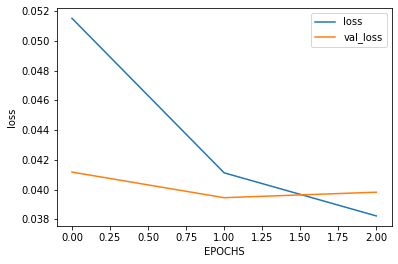

###### DONE PLOTTING FOR IDEA - 1 ########


In [32]:
InappContentModel1.Plot( "loss")

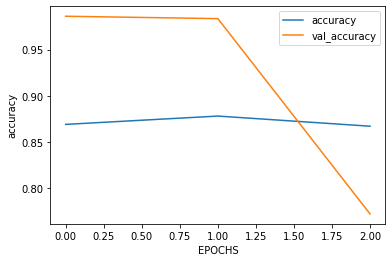

###### DONE PLOTTING FOR IDEA - 1 ########


In [33]:
InappContentModel1.Plot( "accuracy")

In [34]:
%%time
# CHECKING FOR IDEA 2 BY SWITCHING 

InappContentModel1.change_idea_for_same_object( change_idea_to = "2", automatic_train = True)

Framework is changeed succesfully 
 Idea/Frameowkr earlier :  1 
 Idea/Framework Now 2 : 


 PS: This method will keep in handy when you want to test for multiple idea without doing preprocessing step again.
Note: The training is requested to be done AUTOMATICALLY as automatic_train flag is True, Note:  This training will be done on default parameters 
 i.e lr = 0.0, 
 lr_d = 0.0, 
 units = 0, 
 dr = 0.0, 
 epochs=10.
OR The parameters which was set for earlier IDEA/FRAMEWORK
TRAINING STARTED
6
Epoch 1/30
1122/1122 [==============================] - 191s 161ms/step - loss: 0.0517 - accuracy: 0.8620 - val_loss: 0.0431 - val_accuracy: 0.3620

 ROC-AUC - epoch: 1 - score: 0.989942

Epoch 00001: val_loss improved from inf to 0.04314, saving model to best_model_FrameWork2_Inappropriate-Content-Detection.hdf5
Epoch 2/30
1122/1122 [==============================] - 178s 158ms/step - loss: 0.0410 - accuracy: 0.8941 - val_loss: 0.0392 - val_accuracy: 0.9849

 ROC-AUC - epoch: 2 - score: 0.99099

In [35]:
%%time
# Note this prediction is  FOR IDEA 2
y_pred_train = InappContentModel1.get_accuracy_for_training_set()

4488/4488 [==============================] - 145s 32ms/step

 ROC-AUC - ON Validation Dataset - score: 99.24199999999999%
CPU times: user 2min 10s, sys: 7.7 s, total: 2min 18s
Wall time: 3min 24s


In [36]:
%%time
# Note this prediction is  FOR IDEA 2 
y_pred_valid  = InappContentModel1.get_accuracy_for_validation_set()

499/499 [==============================] - 16s 32ms/step

 ROC-AUC - ON Validation Dataset - score: 99.1%
CPU times: user 14.2 s, sys: 899 ms, total: 15.1 s
Wall time: 20.5 s


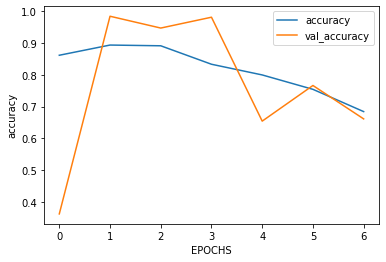

###### DONE PLOTTING FOR IDEA - 2 ########


In [37]:
# Note this prediction is  FOR IDEA 2
InappContentModel1.Plot( "accuracy")

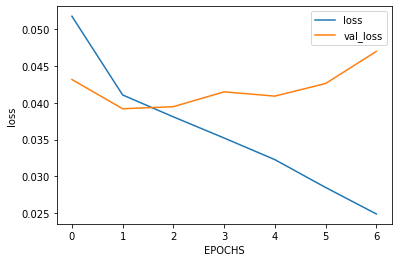

###### DONE PLOTTING FOR IDEA - 2 ########


In [39]:
# Note this prediction is  FOR IDEA 2 
InappContentModel1.Plot( "loss")

**SPAM detection**


In [7]:
%%time
spamDetectionModel1Preprocessor = Preprocessor( embed_size = 300, 
                                               max_features = 130000, 
                                               max_len = 220, 
                                               model_Type = "Spam-Detection")

CPU times: user 24 µs, sys: 4 µs, total: 28 µs
Wall time: 31.2 µs


In [8]:
%%time
spamDetectionModel1Preprocessor.preprocessing( validation_size=0.1,
                                  embedding_path_fastText = "../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec",
                                  embedding_path_glove ="../input/glove840b300dtxt/glove.840B.300d.txt" ,
                                  isEmbeddingIndexFileSaved     =False,
                                  isEmbeddingMatrixFileSaved    = False,
                                  wantToSaveEmbeedingIndexFile  = False,
                                  wantToSaveEmbeedingMatrixFile = False )

Building Trainning and Testing is Done.
Spliting Trainning and Testing is Done.
(7713,)
Tokenizing is Done.
Embeeding Index for Fasttext is Done.
Embeeding Index for Glove is Done.
Embedding Matrix for FastText is Done., with it's shape as None
Embedding Matrix for Glove is Done with shape as None
CPU times: user 5min 23s, sys: 11.1 s, total: 5min 34s
Wall time: 5min 44s


In [16]:
%%time
spamDetectionModel1 = ML_Model( spamDetectionModel1Preprocessor,
                               file_path = "1",
                               n_multiClassificationClasses = 1 )

CPU times: user 59 µs, sys: 3 µs, total: 62 µs
Wall time: 65.6 µs


In [17]:
%%time
spamDetectionModel1.train_Model(lr = 1e-3, lr_d = 0, units = 112, dr = 0.2,epochs = 3 )

TRAINING STARTED


2022-02-27 16:22:36.811058: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 43504800 exceeds 10% of free system memory.
2022-02-27 16:22:36.910835: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 43504800 exceeds 10% of free system memory.


1
Epoch 1/3
61/61 [==============================] - 23s 192ms/step - loss: 0.1853 - accuracy: 0.9280 - val_loss: 0.0981 - val_accuracy: 0.9697

 ROC-AUC - epoch: 1 - score: 0.983952

Epoch 00001: val_loss improved from inf to 0.09813, saving model to best_model_FrameWork1_Spam-Detection.hdf5


2022-02-27 16:23:04.644261: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 43504800 exceeds 10% of free system memory.


Epoch 2/3
61/61 [==============================] - 10s 158ms/step - loss: 0.0565 - accuracy: 0.9821 - val_loss: 0.0712 - val_accuracy: 0.9744

 ROC-AUC - epoch: 2 - score: 0.993359

Epoch 00002: val_loss improved from 0.09813 to 0.07122, saving model to best_model_FrameWork1_Spam-Detection.hdf5
Epoch 3/3
61/61 [==============================] - 10s 159ms/step - loss: 0.0325 - accuracy: 0.9908 - val_loss: 0.0518 - val_accuracy: 0.9860

 ROC-AUC - epoch: 3 - score: 0.995810

Epoch 00003: val_loss improved from 0.07122 to 0.05178, saving model to best_model_FrameWork1_Spam-Detection.hdf5
TRAINING COMPLETED
CPU times: user 45.8 s, sys: 2.42 s, total: 48.2 s
Wall time: 55.7 s


In [18]:
%%time
y_pred_valid  = spamDetectionModel1.get_accuracy_for_validation_set()

27/27 [==============================] - 3s 36ms/step

 ROC-AUC - ON Validation Dataset - score: 99.581%
CPU times: user 2.72 s, sys: 72.2 ms, total: 2.8 s
Wall time: 3.16 s


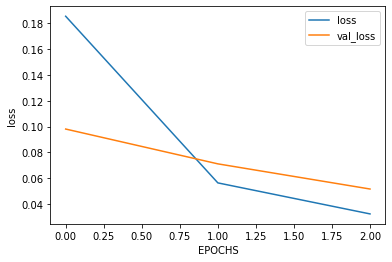

###### DONE PLOTTING FOR IDEA - 1 ########


In [19]:
spamDetectionModel1.Plot( "loss")

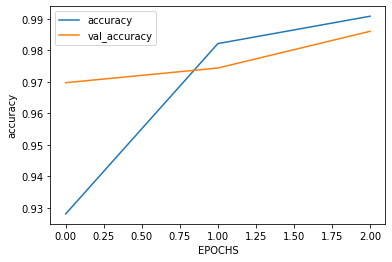

###### DONE PLOTTING FOR IDEA - 1 ########


In [20]:
spamDetectionModel1.Plot( "accuracy")

In [21]:
%%time
# CHECKING FOR IDEA 2 BY SWITCHING 
spamDetectionModel1.change_idea_for_same_object( change_idea_to = "2", automatic_train = True)

Framework is changeed succesfully 
 Idea/Frameowkr earlier :  1 
 Idea/Framework Now 2 : 


 PS: This method will keep in handy when you want to test for multiple idea without doing preprocessing step again.
Note: The training is requested to be done AUTOMATICALLY as automatic_train flag is True, Note:  This training will be done on default parameters 
 i.e lr = 0.0, 
 lr_d = 0.0, 
 units = 0, 
 dr = 0.0, 
 epochs=10.
OR The parameters which was set for earlier IDEA/FRAMEWORK
TRAINING STARTED
1
Epoch 1/30
61/61 [==============================] - 22s 191ms/step - loss: 0.1679 - accuracy: 0.9445 - val_loss: 0.1071 - val_accuracy: 0.9662

 ROC-AUC - epoch: 1 - score: 0.987216

Epoch 00001: val_loss improved from inf to 0.10714, saving model to best_model_FrameWork2_Spam-Detection.hdf5
Epoch 2/30
61/61 [==============================] - 10s 161ms/step - loss: 0.0489 - accuracy: 0.9865 - val_loss: 0.0634 - val_accuracy: 0.9802

 ROC-AUC - epoch: 2 - score: 0.993798

Epoch 00002: val_loss im

In [22]:
%%time
# Note this prediction is  FOR IDEA 2
y_pred_train = spamDetectionModel1.get_accuracy_for_training_set()

242/242 [==============================] - 12s 36ms/step

 ROC-AUC - ON Validation Dataset - score: 100.0%
CPU times: user 10.3 s, sys: 426 ms, total: 10.7 s
Wall time: 13.6 s


In [23]:
%%time
# Note this prediction is  FOR IDEA 2 
y_pred_valid  = spamDetectionModel1.get_accuracy_for_validation_set()

27/27 [==============================] - 1s 36ms/step

 ROC-AUC - ON Validation Dataset - score: 99.884%
CPU times: user 785 ms, sys: 50.9 ms, total: 836 ms
Wall time: 1.31 s


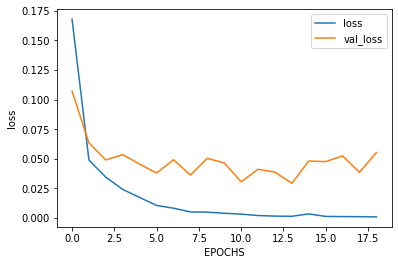

###### DONE PLOTTING FOR IDEA - 2 ########


In [24]:
# Note this prediction is  FOR IDEA 2 
spamDetectionModel1.Plot( "loss")

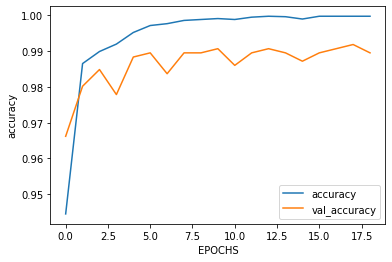

###### DONE PLOTTING FOR IDEA - 2 ########


In [25]:
# Note this prediction is  FOR IDEA 2
spamDetectionModel1.Plot( "accuracy")

In [7]:
# %%time
# spamDetectionModel2 = Preprocessor( embed_size = 300, 
#                                max_features = 130000, 
#                                max_len = 220, 
#                                model_Type = "Spam-Detection", 
#                                file_path = "2", 
#                                n_multiClassificationClasses = 1)

CPU times: user 173 µs, sys: 34 µs, total: 207 µs
Wall time: 231 µs


In [8]:
# %%time
# spamDetectionModel2.preprocessing( validation_size=0.1,
#                                   embedding_path_fastText = "../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec",
#                                   embedding_path_glove ="../input/glove840b300dtxt/glove.840B.300d.txt" )

Building Trainning and Testing is Done.
Spliting Trainning and Testing is Done.
(7713,)
Tokenizing is Done.
Embeeding Index for Fasttext is Done.
Embeeding Index for Glove is Done
Embedding Matrix for FastText is Done.
Embedding Matrix for Glove is Done.
CPU times: user 6min 27s, sys: 19.8 s, total: 6min 47s
Wall time: 6min 53s


In [9]:
# %%time
# spamDetectionModel2.train_Model(lr = 1e-3, lr_d = 0, units = 112, dr = 0.2,epochs = 30 )

TRAINING STARTED


2022-02-26 19:38:54.171382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 19:38:54.286688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 19:38:54.287841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 19:38:54.291305: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/30


2022-02-26 19:39:15.091894: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


61/61 [==============================] - 34s 209ms/step - loss: 0.1731 - accuracy: 0.9369 - val_loss: 0.0884 - val_accuracy: 0.9709

 ROC-AUC - epoch: 1 - score: 0.986906

Epoch 00001: val_loss improved from inf to 0.08836, saving model to best_model_FrameWork2_Spam-Detection.hdf5


2022-02-26 19:39:37.862552: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 43504800 exceeds 10% of free system memory.
2022-02-26 19:39:37.972124: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 43504800 exceeds 10% of free system memory.


Epoch 2/30
61/61 [==============================] - 10s 166ms/step - loss: 0.0492 - accuracy: 0.9844 - val_loss: 0.0753 - val_accuracy: 0.9720

 ROC-AUC - epoch: 2 - score: 0.991529

Epoch 00002: val_loss improved from 0.08836 to 0.07531, saving model to best_model_FrameWork2_Spam-Detection.hdf5


2022-02-26 19:39:49.245906: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 43504800 exceeds 10% of free system memory.


Epoch 3/30
61/61 [==============================] - 10s 164ms/step - loss: 0.0321 - accuracy: 0.9901 - val_loss: 0.0492 - val_accuracy: 0.9837

 ROC-AUC - epoch: 3 - score: 0.994868

Epoch 00003: val_loss improved from 0.07531 to 0.04921, saving model to best_model_FrameWork2_Spam-Detection.hdf5
Epoch 4/30
61/61 [==============================] - 10s 166ms/step - loss: 0.0231 - accuracy: 0.9933 - val_loss: 0.0556 - val_accuracy: 0.9848

 ROC-AUC - epoch: 4 - score: 0.996142

Epoch 00004: val_loss did not improve from 0.04921
Epoch 5/30
61/61 [==============================] - 10s 166ms/step - loss: 0.0173 - accuracy: 0.9946 - val_loss: 0.0469 - val_accuracy: 0.9848

 ROC-AUC - epoch: 5 - score: 0.997544

Epoch 00005: val_loss improved from 0.04921 to 0.04688, saving model to best_model_FrameWork2_Spam-Detection.hdf5
Epoch 6/30
61/61 [==============================] - 10s 164ms/step - loss: 0.0114 - accuracy: 0.9968 - val_loss: 0.0482 - val_accuracy: 0.9883

 ROC-AUC - epoch: 6 - score:

In [10]:
# %%time
# y_pred_train = spamDetectionModel2.get_accuracy_for_training_set()

27/27 [==============================] - 4s 33ms/step

 ROC-AUC - ON Validation Dataset - score: 99.786%
CPU times: user 3.62 s, sys: 117 ms, total: 3.74 s
Wall time: 3.82 s


In [11]:
# %%time
# y_pred_valid  = spamDetectionModel2.get_accuracy_for_validation_set()

242/242 [==============================] - 8s 32ms/step

 ROC-AUC - ON Validation Dataset - score: 99.99900000000001%
CPU times: user 8.33 s, sys: 683 ms, total: 9.01 s
Wall time: 7.89 s


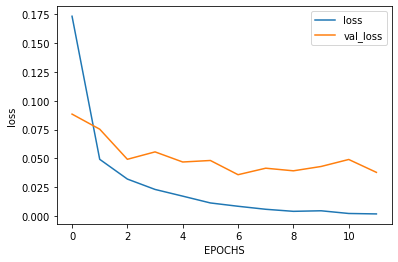

###### DONE PLOTTING FOR IDEA - 2 ########


In [12]:
# spamDetectionModel2.Plot( "loss")

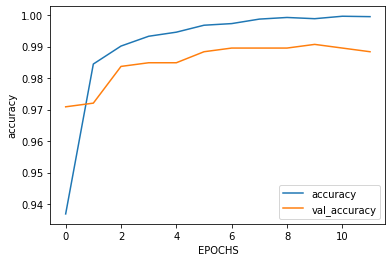

###### DONE PLOTTING FOR IDEA - 2 ########


In [13]:
# spamDetectionModel2.Plot( "accuracy")

In [15]:
# %%time
# # CHECKING FOR IDEA 1 BY SWITCHING 

# spamDetectionModel2.change_idea_for_same_object( change_idea_to = "1", automatic_train = True)

Framework is changeed succesfully 
 Idea/Frameowkr earlier :  2 
 Idea/Framework Now 1 : 


 PS: This method will keep in handy when you want to test for multiple idea without doing preprocessing step again.
Note: The training is requested to be done AUTOMATICALLY as automatic_train flag is True, Note:  This training will be done on default parameters 
 i.e lr = 0.0, 
 lr_d = 0.0, 
 units = 0, 
 dr = 0.0, 
 epochs=10.
TRAINING STARTED
Epoch 1/30
61/61 [==============================] - 28s 210ms/step - loss: 0.1949 - accuracy: 0.9232 - val_loss: 0.0925 - val_accuracy: 0.9709

 ROC-AUC - epoch: 1 - score: 0.986531

Epoch 00001: val_loss did not improve from 0.03587
Epoch 2/30
61/61 [==============================] - 10s 163ms/step - loss: 0.0581 - accuracy: 0.9811 - val_loss: 0.0609 - val_accuracy: 0.9802

 ROC-AUC - epoch: 2 - score: 0.993841

Epoch 00002: val_loss did not improve from 0.03587
Epoch 3/30
61/61 [==============================] - 10s 164ms/step - loss: 0.0332 - accuracy:

In [16]:
# %%time
# # Note this prediction is  FOR IDEA 1 
# y_pred_train = spamDetectionModel2.get_accuracy_for_training_set()

27/27 [==============================] - 4s 33ms/step

 ROC-AUC - ON Validation Dataset - score: 99.79599999999999%
CPU times: user 3.66 s, sys: 97.8 ms, total: 3.76 s
Wall time: 3.6 s


In [17]:
# %%time
# # Note this prediction is  FOR IDEA 1 
# y_pred_valid  = spamDetectionModel2.get_accuracy_for_validation_set()

242/242 [==============================] - 8s 33ms/step

 ROC-AUC - ON Validation Dataset - score: 99.998%
CPU times: user 8.37 s, sys: 680 ms, total: 9.05 s
Wall time: 10.3 s
